# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 3: benchmarking on audio dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchaudio
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

# audio signal augmentation packages
import audiomentations
import torch_audiomentations
from audiomentations import Compose, AddGaussianNoise
from audiomentations import Normalize
# from audiomentations import BandPassFilter, Gain, HighPassFilter

from torch_audiomentations import PolarityInversion

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize

from audio_models import * 
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns
from itertools import cycle
import itertools

In [2]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'class_name_v3','train_audio')
os.makedirs(IMAGE_PATH, exist_ok=True)

model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', 'class_name_v3', 'audio_model')
os.makedirs(model_path, exist_ok=True)

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

np.random.seed(0)
torch.manual_seed(0)

In [3]:
# classes = ('Defect-free', 'Defective', 'Laser-off')
classes = ('Defect-free', 'Keyhole pores', 'Laser defocus', 'Laser-off')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100

### Use GPU if possible

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
mp.set_start_method(method='forkserver', force=True)

Using cuda


In [16]:
torch.manual_seed(0)

### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [5]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name_v3'])

df_multimodal

,sample index,Time_Stamps,audio_file_name,image_file_name,class_name,class_name_v2,Layer number,Sample number,class_name_v3,rms_energy,...,center_y,contour_area,contour_length,X,Y,Z,Vx,Vy,Vz,Speed
0,1,0.00,sample_21_1.wav,sample_21_1.jpg,Laser-off,Laser-off,1.0,21,Laser-off,0.009018,...,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
1,2,0.04,sample_21_2.wav,sample_21_2.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.019286,...,239.000000,305442.0,2234.000000,0.000,-0.000,0.001,-0.074,-0.074,0.000,0.105
2,3,0.08,sample_21_3.wav,sample_21_3.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.019593,...,239.000000,305442.0,2234.000000,-0.010,0.015,-0.007,-0.051,0.026,-0.051,0.077
3,4,0.12,sample_21_4.wav,sample_21_4.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.030937,...,230.264496,291865.5,2279.781744,-0.007,0.016,0.010,0.173,-0.222,2.520,2.536
4,5,0.16,sample_21_5.wav,sample_21_5.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.038329,...,229.109962,281970.0,2407.847760,-0.111,0.123,-0.057,-1.864,1.662,-2.468,3.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48461,10982,439.24,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.011000,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48462,10983,439.28,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.008347,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48463,10984,439.32,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.011081,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48464,10985,439.36,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.011044,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080


In [6]:
# Get the labels and count the number of samples for each class
labels = df_multimodal['class_name_v3'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 7601  4991  6208 17757]


In [7]:
def get_sample_directories_from_df(df, Dataset_path):
    # Extract unique sample numbers from the DataFrame
    unique_sample_numbers = df['Sample number'].unique()
    
    # Generate the full paths for image and audio directories
    image_directories = [os.path.join(Dataset_path, str(sample_number), 'images') for sample_number in unique_sample_numbers]
    audio_directories = [os.path.join(Dataset_path, str(sample_number), 'raw_audio') for sample_number in unique_sample_numbers]
    
    return image_directories, audio_directories

samples = [21, 22, 23, 24, 26, 32]
image_directories, audio_directories = get_sample_directories_from_df(df_multimodal, Dataset_path)

### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **55%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [8]:
### Get the percentage distribution of each category
round(df_multimodal.groupby('class_name_v3')["class_name_v3"].count()/df_multimodal.shape[0]*100, 1)

class_name_v3
Defect-free      20.8
Keyhole pores    13.7
Laser defocus    17.0
Laser-off        48.6
Name: class_name_v3, dtype: float64

Saving figure dataset_distribution.png


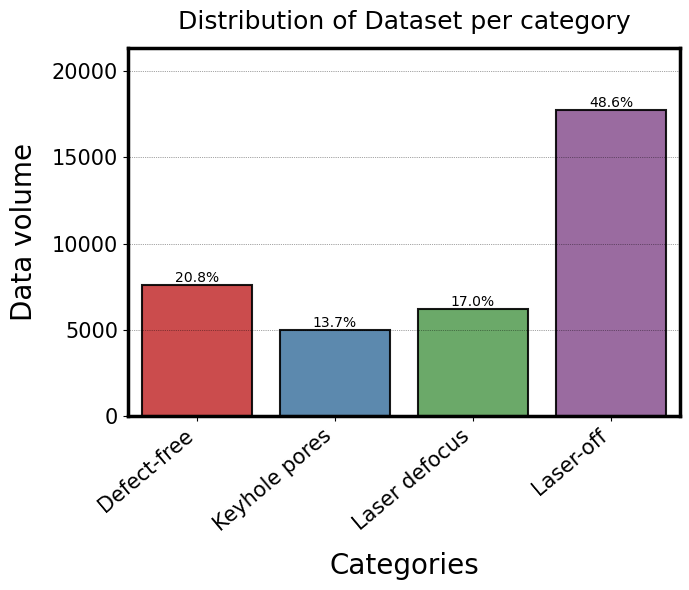

In [9]:
filename = 'dataset_distribution'
plot_data_distribution(df_multimodal, 'class_name_v3', 
                       'Distribution of Dataset per category', filename)
save_fig(f"{filename}.png")

## Preparing Dataset and DataLoader

#### Data Augmentation methods

In [10]:
#------ transformation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=256,
    n_mels=32
)

# MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)



# augmentation = Compose(
#     [
#        AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.002, p=0.5),
#        # HighPassFilter(min_cutoff_freq=1000, max_cutoff_freq=21000, p=0.5),
#        BandPassFilter(min_center_freq=1000, max_center_freq=21000, p=0.5),
#        # Gain(min_gain_in_db = -2, max_gain_in_db = 2, p=0.5),
#        Normalize(p=0.5)
#     ]
# )


# # Initialize augmentation callable
# apply_augmentation = Compose(
#     transforms=[
#         # Gain(
#         #     min_gain_in_db=-15.0,
#         #     max_gain_in_db=5.0,
#         #     p=0.5,
#         # ),
#         PolarityInversion(p=0.5)
#     ]
# )

# train_transform = transforms.Compose([
#     augmentation,
#     apply_augmentation,
#     # torchaudio.transforms.TimeMasking(time_mask_param=20, p=0.5),  # apply time masking with probability of 0.5
#     # torchaudio.transforms.FrequencyMasking(freq_mask_param=20),  # apply time masking with probability of 0.5
#     torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=512, hop_length=256, n_mels=32),  # compute Mel-frequency cepstral coefficients (MFCCs)
# ])


In [11]:
#------ data loader------
# create the dataset for all samples
audiodataset = LDEDAudioDataset(df_multimodal,
                                audio_directories,
                                samples,
                                mel_spectrogram,
                                # MFCCs,
                                # spectral_centroid,
                                SAMPLE_RATE,
                                device)
print ("length of the total dataset:" + str(len(audiodataset)))

length of the total dataset:36557


## Train Val Test dataset 

In [12]:
%store -r train_indices
%store -r val_indices
%store -r test_indices

In [13]:
# Create train, val, and test datasets for deep learning models
train_annotations = df_multimodal.iloc[train_indices, :]
val_annotations = df_multimodal.iloc[val_indices, :]
test_annotations = df_multimodal.iloc[test_indices, :]

train_dataset = LDEDAudioDataset(train_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)
val_dataset = LDEDAudioDataset(val_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)
test_dataset = LDEDAudioDataset(test_annotations, audio_directories, samples, mel_spectrogram, SAMPLE_RATE, device=device)

### Create DataLoader using the dataset

In [32]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:29245
length of the val dataset:3656
length of the test dataset:3656


### Hyperparameter tuning

In [20]:
# Importing required libraries
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tqdm import tqdm
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


#Objective function
def objective(params):
    # Initialize your model
    net = MFCCCNN(dropout_rate=params['dropout_rate'])
    net = net.to(device)
    
    # Loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    if params['optimizer'] == 'adam':
        optimizer = optim.Adam(net.parameters(), lr=params['learning_rate'], weight_decay=params['regularization'])
    else:
        optimizer = optim.SGD(net.parameters(), lr=params['learning_rate'], momentum=params['momentum'], weight_decay=params['regularization'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Create DataLoaders
    BATCH_SIZE = int(params['batch_size'])
    
     # Use a subset of the dataset for hyperparameter tuning
    n_train = int(len(train_dataset) * 0.2)  # 20% of the training set
    n_val = int(len(val_dataset) * 0.1)  # 10% of the validation set
    
    subset_train_dataset = torch.utils.data.Subset(train_dataset, np.random.choice(len(train_dataset), n_train, replace=False))
    subset_val_dataset = torch.utils.data.Subset(val_dataset, np.random.choice(len(val_dataset), n_val, replace=False))
    
    train_dataloader = DataLoader(subset_train_dataset, batch_size=int(params['batch_size']), shuffle=True, num_workers=4)
    val_dataloader = DataLoader(subset_val_dataset, batch_size=int(params['batch_size']), shuffle=False, num_workers=4)
    
    # Training loop
    _, _, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(
        model=net, 
        loss_fn=loss_fn, 
        optimizer=optimizer, 
        train_loader=train_dataloader, 
        valid_loader=val_dataloader, 
        epochs=5,  # adjust this
        scheduler=scheduler,
        device=device, 
        print_every=1,
        mode="single_model"
    )
    
    min_valid_loss = min(valid_losses)
    max_valid_accuracy = max(valid_accuracy)
    
    return {'loss': min_valid_loss, 'status': STATUS_OK, 'best_accuracy': max_valid_accuracy}


# Define hyperparameter space
space = {
    'batch_size': hp.choice('batch_size', [32, 64, 128]),
    'optimizer': hp.choice('optimizer', ['adam', 'sgd']),
    'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
    'learning_rate': hp.loguniform('learning_rate', -7, -2),
    'momentum': hp.uniform('momentum', 0.7, 0.99),
    'regularization': hp.choice('regularization', [1e-3, 1e-4, 1e-5])
}

# Run optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

                                                                                     
Epoch: 0
  0%|                                         | 0/10 [00:00<?, ?trial/s, best loss=?]

Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.38, accuracy=20.3]

Epoch 0:   1%|1         | 1/92 [00:07<11:22,  7.50s/it, loss=1.38, accuracy=20.3]

Epoch 0:   1%|1         | 1/92 [00:07<11:22,  7.50s/it, loss=1.35, accuracy=34.4]

Epoch 0:   2%|2         | 2/92 [00:07<04:49,  3.22s/it, loss=1.35, accuracy=34.4]

Epoch 0:   2%|2         | 2/92 [00:07<04:49,  3.22s/it, loss=1.31, accuracy=39.6]

Epoch 0:   3%|3         | 3/92 [00:07<02:42,  1.83s/it, loss=1.31, accuracy=39.6]

Epoch 0:   3%|3         | 3/92 [00:09<02:42,  1.83s/it, loss=1.31, accuracy=40.6]

Epoch 0:   4%|4         | 4/92 [00:09<02:22,  1.62s/it, loss=1.31, accuracy=40.6]

Epoch 0:   4%|4         | 4/92 [00:09<02:22,  1.62s/it, loss=1.29, accuracy=43.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:22,  1.62s/it, loss=1.28, accuracy=44.5]

Epoch 0:   4%|4         | 4/92 [00:09<02:22,  1.62s/it, loss=1.26, accuracy=47.1]

Epoch 0:   4%|4         | 4/92 [00:09<02:22,  

17:53:48 --- Epoch: 0	Train loss: 1.2683	Valid loss: 0.0205	Train accuracy: 47.43	Valid accuracy: 49.59
                                                                                     
Epoch: 1
  0%|                                         | 0/10 [00:19<?, ?trial/s, best loss=?]

Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.21, accuracy=53.1]

Epoch 1:   1%|1         | 1/92 [00:07<11:19,  7.47s/it, loss=1.21, accuracy=53.1]

Epoch 1:   1%|1         | 1/92 [00:07<11:19,  7.47s/it, loss=1.24, accuracy=50.8]

Epoch 1:   1%|1         | 1/92 [00:07<11:19,  7.47s/it, loss=1.27, accuracy=47.4]

Epoch 1:   3%|3         | 3/92 [00:07<03:03,  2.06s/it, loss=1.27, accuracy=47.4]

Epoch 1:   3%|3         | 3/92 [00:09<03:03,  2.06s/it, loss=1.27, accuracy=47.7]

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.27, accuracy=47.7]

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.26, accuracy=48.4]

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.25, accuracy=49]  

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.25, accuracy=49.8]

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.25, accuracy=49.8]

Epoch 1:   4%|4         | 4/92 [00:09<02:39,  

17:54:08 --- Epoch: 1	Train loss: 1.2660	Valid loss: 0.0205	Train accuracy: 47.77	Valid accuracy: 49.59
                                                                                     
Epoch: 2
  0%|                                         | 0/10 [00:39<?, ?trial/s, best loss=?]

Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.4, accuracy=34.4]

Epoch 2:   1%|1         | 1/92 [00:07<11:18,  7.45s/it, loss=1.4, accuracy=34.4]

Epoch 2:   1%|1         | 1/92 [00:07<11:18,  7.45s/it, loss=1.31, accuracy=43.8]

Epoch 2:   1%|1         | 1/92 [00:07<11:18,  7.45s/it, loss=1.26, accuracy=47.9]

Epoch 2:   1%|1         | 1/92 [00:08<11:18,  7.45s/it, loss=1.29, accuracy=45.7]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.29, accuracy=45.7]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.28, accuracy=46.6]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.26, accuracy=48.2]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.27, accuracy=47.5]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.27, accuracy=47.5]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.77s/it, loss=1.27, accuracy=47.6]

Epoch 2:   4%|4         | 4/92 [00:08<02:35,  1.

17:54:27 --- Epoch: 2	Train loss: 1.2660	Valid loss: 0.0205	Train accuracy: 47.77	Valid accuracy: 49.59
                                                                                     
Epoch: 3
  0%|                                         | 0/10 [00:58<?, ?trial/s, best loss=?]

Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.29, accuracy=45.3]

Epoch 3:   1%|1         | 1/92 [00:07<11:39,  7.69s/it, loss=1.29, accuracy=45.3]

Epoch 3:   1%|1         | 1/92 [00:07<11:39,  7.69s/it, loss=1.29, accuracy=45.3]

Epoch 3:   1%|1         | 1/92 [00:07<11:39,  7.69s/it, loss=1.31, accuracy=43.2]

Epoch 3:   3%|3         | 3/92 [00:07<03:04,  2.07s/it, loss=1.31, accuracy=43.2]

Epoch 3:   3%|3         | 3/92 [00:09<03:04,  2.07s/it, loss=1.31, accuracy=43]  

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77s/it, loss=1.31, accuracy=43]

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77s/it, loss=1.3, accuracy=44.1]

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77s/it, loss=1.3, accuracy=44.5]

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77s/it, loss=1.31, accuracy=43.5]

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77s/it, loss=1.3, accuracy=44.1] 

Epoch 3:   4%|4         | 4/92 [00:09<02:36,  1.77

17:54:47 --- Epoch: 3	Train loss: 1.2660	Valid loss: 0.0205	Train accuracy: 47.77	Valid accuracy: 49.59
                                                                                     
Epoch: 4
  0%|                                         | 0/10 [01:18<?, ?trial/s, best loss=?]

Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.32, accuracy=42.2]

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.33s/it, loss=1.32, accuracy=42.2]

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.33s/it, loss=1.31, accuracy=43.8]

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.33s/it, loss=1.3, accuracy=44.8] 

Epoch 4:   1%|1         | 1/92 [00:08<11:06,  7.33s/it, loss=1.28, accuracy=46.1]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.28, accuracy=46.1]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.29, accuracy=45.3]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.28, accuracy=46.4]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.29, accuracy=45.1]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.3, accuracy=44.5] 

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  1.76s/it, loss=1.29, accuracy=45.3]

Epoch 4:   4%|4         | 4/92 [00:08<02:34,  

17:55:06 --- Epoch: 4	Train loss: 1.2660	Valid loss: 0.0205	Train accuracy: 47.77	Valid accuracy: 49.59
                                                                                     
Epoch: 0
 10%|█▍            | 1/10 [01:37<14:35, 97.24s/trial, best loss: 0.02049949299799253]

Epoch 0:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.39, accuracy=12.5]

Epoch 0:   1%|          | 1/183 [00:07<22:43,  7.49s/it, loss=1.39, accuracy=12.5]

Epoch 0:   1%|          | 1/183 [00:07<22:43,  7.49s/it, loss=1.39, accuracy=12.5]

Epoch 0:   1%|          | 1/183 [00:07<22:43,  7.49s/it, loss=1.39, accuracy=15.6]

Epoch 0:   2%|1         | 3/183 [00:07<06:06,  2.04s/it, loss=1.39, accuracy=15.6]

Epoch 0:   2%|1         | 3/183 [00:08<06:06,  2.04s/it, loss=1.39, accuracy=14.8]

Epoch 0:   2%|2         | 4/183 [00:08<05:06,  1.71s/it, loss=1.39, accuracy=14.8]

Epoch 0:   2%|2         | 4/183 [00:08<05:06,  1.71s/it, loss=1.39, accuracy=15]  

Epoch 0:   2%|2         | 4/183 [00:08<05:06,  1.71s/it, loss=1.39, accuracy=15.6]

Epoch 0:   2%|2         | 4/183 [00:08<05:06,  1.71s/it, loss=1.39, accuracy=16.1]

Epoch 0:   2%|2         | 4/183 [00:08<05:06,  1.71s/it, loss=1.39, accuracy=18.4]

Epoch 0:   2%|2         | 4/183 [0

17:55:25 --- Epoch: 0	Train loss: 1.2640	Valid loss: 0.0409	Train accuracy: 47.87	Valid accuracy: 49.86
                                                                                     
Epoch: 1
 10%|█▍            | 1/10 [01:56<14:35, 97.24s/trial, best loss: 0.02049949299799253]

Epoch 1:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.15, accuracy=59.4]

Epoch 1:   1%|          | 1/183 [00:07<23:00,  7.59s/it, loss=1.15, accuracy=59.4]

Epoch 1:   1%|          | 1/183 [00:07<23:00,  7.59s/it, loss=1.18, accuracy=56.2]

Epoch 1:   1%|          | 1/183 [00:07<23:00,  7.59s/it, loss=1.2, accuracy=54.2] 

Epoch 1:   2%|1         | 3/183 [00:07<06:17,  2.10s/it, loss=1.2, accuracy=54.2]

Epoch 1:   2%|1         | 3/183 [00:09<06:17,  2.10s/it, loss=1.2, accuracy=53.9]

Epoch 1:   2%|2         | 4/183 [00:09<05:16,  1.77s/it, loss=1.2, accuracy=53.9]

Epoch 1:   2%|2         | 4/183 [00:09<05:16,  1.77s/it, loss=1.21, accuracy=53.8]

Epoch 1:   2%|2         | 4/183 [00:09<05:16,  1.77s/it, loss=1.22, accuracy=52.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:16,  1.77s/it, loss=1.21, accuracy=53.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:16,  1.77s/it, loss=1.21, accuracy=53.1]

Epoch 1:   2%|2         | 4/183 [00:0

17:55:46 --- Epoch: 1	Train loss: 1.2537	Valid loss: 0.0409	Train accuracy: 49.00	Valid accuracy: 49.86
                                                                                     
Epoch: 2
 10%|█▍            | 1/10 [02:17<14:35, 97.24s/trial, best loss: 0.02049949299799253]

Epoch 2:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.31, accuracy=43.8]

Epoch 2:   1%|          | 1/183 [00:07<23:38,  7.79s/it, loss=1.31, accuracy=43.8]

Epoch 2:   1%|          | 1/183 [00:07<23:38,  7.79s/it, loss=1.27, accuracy=46.9]

Epoch 2:   1%|1         | 2/183 [00:07<09:51,  3.27s/it, loss=1.27, accuracy=46.9]

Epoch 2:   1%|1         | 2/183 [00:07<09:51,  3.27s/it, loss=1.25, accuracy=49]  

Epoch 2:   1%|1         | 2/183 [00:09<09:51,  3.27s/it, loss=1.25, accuracy=49.2]

Epoch 2:   2%|2         | 4/183 [00:09<05:01,  1.69s/it, loss=1.25, accuracy=49.2]

Epoch 2:   2%|2         | 4/183 [00:09<05:01,  1.69s/it, loss=1.27, accuracy=46.9]

Epoch 2:   2%|2         | 4/183 [00:09<05:01,  1.69s/it, loss=1.29, accuracy=45.8]

Epoch 2:   2%|2         | 4/183 [00:09<05:01,  1.69s/it, loss=1.3, accuracy=44.6] 

Epoch 2:   2%|2         | 4/183 [00:09<05:01,  1.69s/it, loss=1.3, accuracy=44.1]

Epoch 2:   2%|2         | 4/183 [00

17:56:07 --- Epoch: 2	Train loss: 1.2526	Valid loss: 0.0409	Train accuracy: 49.10	Valid accuracy: 49.86
                                                                                     
Epoch: 3
 10%|█▍            | 1/10 [02:38<14:35, 97.24s/trial, best loss: 0.02049949299799253]

Epoch 3:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.18, accuracy=56.2]

Epoch 3:   1%|          | 1/183 [00:07<21:59,  7.25s/it, loss=1.18, accuracy=56.2]

Epoch 3:   1%|          | 1/183 [00:07<21:59,  7.25s/it, loss=1.2, accuracy=54.7] 

Epoch 3:   1%|          | 1/183 [00:07<21:59,  7.25s/it, loss=1.25, accuracy=49] 

Epoch 3:   1%|          | 1/183 [00:08<21:59,  7.25s/it, loss=1.25, accuracy=49.2]

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.25, accuracy=49.2]

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.26, accuracy=48.1]

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.29, accuracy=45.8]

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.27, accuracy=47.3]

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.26, accuracy=48]  

Epoch 3:   2%|2         | 4/183 [00:08<05:16,  1.77s/it, loss=1.26, accuracy=47.9]

Epoch 3:   2%|2         | 4/183 [00

17:56:26 --- Epoch: 3	Train loss: 1.2533	Valid loss: 0.0409	Train accuracy: 49.03	Valid accuracy: 49.86
                                                                                     
Epoch: 4
 10%|█▍            | 1/10 [02:58<14:35, 97.24s/trial, best loss: 0.02049949299799253]

Epoch 4:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.15, accuracy=59.4]

Epoch 4:   1%|          | 1/183 [00:07<22:23,  7.38s/it, loss=1.15, accuracy=59.4]

Epoch 4:   1%|          | 1/183 [00:07<22:23,  7.38s/it, loss=1.2, accuracy=54.7] 

Epoch 4:   1%|1         | 2/183 [00:07<09:21,  3.10s/it, loss=1.2, accuracy=54.7]

Epoch 4:   1%|1         | 2/183 [00:07<09:21,  3.10s/it, loss=1.2, accuracy=54.2]

Epoch 4:   1%|1         | 2/183 [00:09<09:21,  3.10s/it, loss=1.17, accuracy=57.8]

Epoch 4:   2%|2         | 4/183 [00:09<04:58,  1.67s/it, loss=1.17, accuracy=57.8]

Epoch 4:   2%|2         | 4/183 [00:09<04:58,  1.67s/it, loss=1.16, accuracy=58.8]

Epoch 4:   2%|2         | 4/183 [00:09<04:58,  1.67s/it, loss=1.16, accuracy=58.9]

Epoch 4:   2%|2         | 4/183 [00:09<04:58,  1.67s/it, loss=1.18, accuracy=56.7]

Epoch 4:   2%|2         | 4/183 [00:09<04:58,  1.67s/it, loss=1.19, accuracy=55.5]

Epoch 4:   2%|2         | 4/183 [00:

17:56:47 --- Epoch: 4	Train loss: 1.2521	Valid loss: 0.0409	Train accuracy: 49.15	Valid accuracy: 49.86
                                                                                     
Epoch: 0
 20%|██▊           | 2/10 [03:18<13:16, 99.55s/trial, best loss: 0.02049949299799253]

Epoch 0:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.38, accuracy=50]

Epoch 0:   1%|          | 1/183 [00:07<23:42,  7.82s/it, loss=1.38, accuracy=50]

Epoch 0:   1%|          | 1/183 [00:07<23:42,  7.82s/it, loss=1.3, accuracy=59.4]

Epoch 0:   1%|          | 1/183 [00:07<23:42,  7.82s/it, loss=1.28, accuracy=56.2]

Epoch 0:   1%|          | 1/183 [00:09<23:42,  7.82s/it, loss=1.25, accuracy=57]  

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.25, accuracy=57]

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.24, accuracy=56.2]

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.27, accuracy=52.6]

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.28, accuracy=50.9]

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.28, accuracy=50.4]

Epoch 0:   2%|2         | 4/183 [00:09<05:28,  1.84s/it, loss=1.28, accuracy=50]  

Epoch 0:   2%|2         | 4/183 [00:09<05

17:57:08 --- Epoch: 0	Train loss: 1.2551	Valid loss: 0.0420	Train accuracy: 49.02	Valid accuracy: 47.12
                                                                                     
Epoch: 1
 20%|██▊           | 2/10 [03:39<13:16, 99.55s/trial, best loss: 0.02049949299799253]

Epoch 1:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.34, accuracy=40.6]

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.34, accuracy=40.6]

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.4, accuracy=34.4] 

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.37, accuracy=37.5]

Epoch 1:   2%|1         | 3/183 [00:07<05:53,  1.96s/it, loss=1.37, accuracy=37.5]

Epoch 1:   2%|1         | 3/183 [00:09<05:53,  1.96s/it, loss=1.35, accuracy=39.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:28,  1.83s/it, loss=1.35, accuracy=39.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:28,  1.83s/it, loss=1.34, accuracy=40.6]

Epoch 1:   2%|2         | 4/183 [00:09<05:28,  1.83s/it, loss=1.32, accuracy=42.7]

Epoch 1:   2%|2         | 4/183 [00:09<05:28,  1.83s/it, loss=1.3, accuracy=44.6] 

Epoch 1:   2%|2         | 4/183 [00:09<05:28,  1.83s/it, loss=1.29, accuracy=45.7]

Epoch 1:   2%|2         | 4/183 [0

17:57:28 --- Epoch: 1	Train loss: 1.2535	Valid loss: 0.0420	Train accuracy: 49.02	Valid accuracy: 47.12
                                                                                     
Epoch: 2
 20%|██▊           | 2/10 [03:59<13:16, 99.55s/trial, best loss: 0.02049949299799253]

Epoch 2:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.18, accuracy=56.2]

Epoch 2:   1%|          | 1/183 [00:07<21:48,  7.19s/it, loss=1.18, accuracy=56.2]

Epoch 2:   1%|          | 1/183 [00:07<21:48,  7.19s/it, loss=1.2, accuracy=54.7] 

Epoch 2:   1%|          | 1/183 [00:07<21:48,  7.19s/it, loss=1.18, accuracy=56.2]

Epoch 2:   2%|1         | 3/183 [00:07<05:50,  1.95s/it, loss=1.18, accuracy=56.2]

Epoch 2:   2%|1         | 3/183 [00:08<05:50,  1.95s/it, loss=1.2, accuracy=53.9] 

Epoch 2:   2%|2         | 4/183 [00:08<05:09,  1.73s/it, loss=1.2, accuracy=53.9]

Epoch 2:   2%|2         | 4/183 [00:08<05:09,  1.73s/it, loss=1.2, accuracy=54.4]

Epoch 2:   2%|2         | 4/183 [00:08<05:09,  1.73s/it, loss=1.21, accuracy=53.6]

Epoch 2:   2%|2         | 4/183 [00:08<05:09,  1.73s/it, loss=1.22, accuracy=52.7]

Epoch 2:   2%|2         | 4/183 [00:08<05:09,  1.73s/it, loss=1.22, accuracy=52.7]

Epoch 2:   2%|2         | 4/183 [00:

17:57:49 --- Epoch: 2	Train loss: 1.2535	Valid loss: 0.0420	Train accuracy: 49.02	Valid accuracy: 47.12
                                                                                     
Epoch: 3
 20%|██▊           | 2/10 [04:20<13:16, 99.55s/trial, best loss: 0.02049949299799253]

Epoch 3:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.4, accuracy=34.4]

Epoch 3:   1%|          | 1/183 [00:07<21:58,  7.24s/it, loss=1.4, accuracy=34.4]

Epoch 3:   1%|          | 1/183 [00:07<21:58,  7.24s/it, loss=1.27, accuracy=46.9]

Epoch 3:   1%|          | 1/183 [00:07<21:58,  7.24s/it, loss=1.31, accuracy=43.8]

Epoch 3:   1%|          | 1/183 [00:08<21:58,  7.24s/it, loss=1.32, accuracy=42.2]

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.32, accuracy=42.2]

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.28, accuracy=46.2]

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.24, accuracy=50]  

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.26, accuracy=48.7]

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.27, accuracy=46.9]

Epoch 3:   2%|2         | 4/183 [00:08<05:25,  1.82s/it, loss=1.27, accuracy=47.6]

Epoch 3:   2%|2         | 4/183 [00:

17:58:09 --- Epoch: 3	Train loss: 1.2535	Valid loss: 0.0420	Train accuracy: 49.02	Valid accuracy: 47.12
                                                                                     
Epoch: 4
 20%|██▊           | 2/10 [04:40<13:16, 99.55s/trial, best loss: 0.02049949299799253]

Epoch 4:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.24, accuracy=50]

Epoch 4:   1%|          | 1/183 [00:07<22:10,  7.31s/it, loss=1.24, accuracy=50]

Epoch 4:   1%|          | 1/183 [00:07<22:10,  7.31s/it, loss=1.23, accuracy=51.6]

Epoch 4:   1%|          | 1/183 [00:07<22:10,  7.31s/it, loss=1.21, accuracy=53.1]

Epoch 4:   2%|1         | 3/183 [00:07<06:11,  2.06s/it, loss=1.21, accuracy=53.1]

Epoch 4:   2%|1         | 3/183 [00:09<06:11,  2.06s/it, loss=1.27, accuracy=47.7]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.27, accuracy=47.7]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.27, accuracy=47.5]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.26, accuracy=47.9]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.27, accuracy=47.3]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.26, accuracy=48]  

Epoch 4:   2%|2         | 4/183 [00:09

17:58:30 --- Epoch: 4	Train loss: 1.2535	Valid loss: 0.0420	Train accuracy: 49.02	Valid accuracy: 47.12
                                                                                     
Epoch: 0
 30%|███▉         | 3/10 [05:01<11:48, 101.20s/trial, best loss: 0.02049949299799253]

Epoch 0:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/46 [00:07<?, ?it/s, loss=1.39, accuracy=14.8]

Epoch 0:   2%|2         | 1/46 [00:07<05:45,  7.68s/it, loss=1.39, accuracy=14.8]

Epoch 0:   2%|2         | 1/46 [00:07<05:45,  7.68s/it, loss=1.39, accuracy=13.7]

Epoch 0:   2%|2         | 1/46 [00:07<05:45,  7.68s/it, loss=1.39, accuracy=13.8]

Epoch 0:   2%|2         | 1/46 [00:09<05:45,  7.68s/it, loss=1.39, accuracy=15.4]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.39, accuracy=15.4]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.39, accuracy=18.8]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.39, accuracy=23.4]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.39, accuracy=26.3]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.38, accuracy=29.7]

Epoch 0:   9%|8         | 4/46 [00:09<01:17,  1.85s/it, loss=1.38, accuracy=31.8]

Epoch 0:  20%|#9        | 9/46 [00:09<00:23,  

17:58:49 --- Epoch: 0	Train loss: 1.2844	Valid loss: 0.0093	Train accuracy: 49.77	Valid accuracy: 59.73
                                                                                     
Epoch: 1
 30%|███▉         | 3/10 [05:20<11:48, 101.20s/trial, best loss: 0.02049949299799253]

Epoch 1:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/46 [00:07<?, ?it/s, loss=1.1, accuracy=65.6]

Epoch 1:   2%|2         | 1/46 [00:07<05:36,  7.49s/it, loss=1.1, accuracy=65.6]

Epoch 1:   2%|2         | 1/46 [00:07<05:36,  7.49s/it, loss=1.14, accuracy=60.9]

Epoch 1:   2%|2         | 1/46 [00:07<05:36,  7.49s/it, loss=1.15, accuracy=59.6]

Epoch 1:   7%|6         | 3/46 [00:07<01:27,  2.03s/it, loss=1.15, accuracy=59.6]

Epoch 1:   7%|6         | 3/46 [00:08<01:27,  2.03s/it, loss=1.15, accuracy=59.6]

Epoch 1:   9%|8         | 4/46 [00:08<01:13,  1.74s/it, loss=1.15, accuracy=59.6]

Epoch 1:   9%|8         | 4/46 [00:08<01:13,  1.74s/it, loss=1.14, accuracy=60.3]

Epoch 1:   9%|8         | 4/46 [00:08<01:13,  1.74s/it, loss=1.14, accuracy=59.9]

Epoch 1:   9%|8         | 4/46 [00:08<01:13,  1.74s/it, loss=1.13, accuracy=60.5]

Epoch 1:   9%|8         | 4/46 [00:09<01:13,  1.74s/it, loss=1.13, accuracy=61.1]

Epoch 1:   9%|8         | 4/46 [00:09<01:13,  1.

17:59:07 --- Epoch: 1	Train loss: 1.1228	Valid loss: 0.0090	Train accuracy: 61.10	Valid accuracy: 65.21
                                                                                     
Epoch: 2
 30%|███▉         | 3/10 [05:38<11:48, 101.20s/trial, best loss: 0.02049949299799253]

Epoch 2:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/46 [00:07<?, ?it/s, loss=1.09, accuracy=67.2]

Epoch 2:   2%|2         | 1/46 [00:07<05:32,  7.38s/it, loss=1.09, accuracy=67.2]

Epoch 2:   2%|2         | 1/46 [00:07<05:32,  7.38s/it, loss=1.07, accuracy=68.4]

Epoch 2:   2%|2         | 1/46 [00:07<05:32,  7.38s/it, loss=1.11, accuracy=62.5]

Epoch 2:   2%|2         | 1/46 [00:09<05:32,  7.38s/it, loss=1.11, accuracy=63.3]

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.11, accuracy=63.3]

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.12, accuracy=61.6]

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.11, accuracy=62.5]

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.09, accuracy=64.3]

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.1, accuracy=63.4] 

Epoch 2:   9%|8         | 4/46 [00:09<01:18,  1.87s/it, loss=1.1, accuracy=63.7]

Epoch 2:  20%|#9        | 9/46 [00:09<00:24,  1

17:59:25 --- Epoch: 2	Train loss: 1.0869	Valid loss: 0.0087	Train accuracy: 65.12	Valid accuracy: 66.58
                                                                                     
Epoch: 3
 30%|███▉         | 3/10 [05:56<11:48, 101.20s/trial, best loss: 0.02049949299799253]

Epoch 3:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/46 [00:07<?, ?it/s, loss=1.05, accuracy=70.3]

Epoch 3:   2%|2         | 1/46 [00:07<05:33,  7.40s/it, loss=1.05, accuracy=70.3]

Epoch 3:   2%|2         | 1/46 [00:07<05:33,  7.40s/it, loss=1.09, accuracy=64.8]

Epoch 3:   2%|2         | 1/46 [00:07<05:33,  7.40s/it, loss=1.08, accuracy=64.8]

Epoch 3:   7%|6         | 3/46 [00:07<01:26,  2.02s/it, loss=1.08, accuracy=64.8]

Epoch 3:   7%|6         | 3/46 [00:08<01:26,  2.02s/it, loss=1.07, accuracy=66.6]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  1.74s/it, loss=1.07, accuracy=66.6]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  1.74s/it, loss=1.07, accuracy=65.9]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  1.74s/it, loss=1.07, accuracy=65.8]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  1.74s/it, loss=1.08, accuracy=65.2]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  1.74s/it, loss=1.07, accuracy=65.7]

Epoch 3:   9%|8         | 4/46 [00:08<01:12,  

17:59:43 --- Epoch: 3	Train loss: 1.0678	Valid loss: 0.0085	Train accuracy: 66.49	Valid accuracy: 70.14
                                                                                     
Epoch: 4
 30%|███▉         | 3/10 [06:14<11:48, 101.20s/trial, best loss: 0.02049949299799253]

Epoch 4:   0%|          | 0/46 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/46 [00:07<?, ?it/s, loss=1.07, accuracy=68]

Epoch 4:   2%|2         | 1/46 [00:07<05:29,  7.31s/it, loss=1.07, accuracy=68]

Epoch 4:   2%|2         | 1/46 [00:07<05:29,  7.31s/it, loss=1.03, accuracy=71.1]

Epoch 4:   2%|2         | 1/46 [00:07<05:29,  7.31s/it, loss=1.04, accuracy=70.1]

Epoch 4:   7%|6         | 3/46 [00:07<01:28,  2.06s/it, loss=1.04, accuracy=70.1]

Epoch 4:   7%|6         | 3/46 [00:08<01:28,  2.06s/it, loss=1.03, accuracy=71.1]

Epoch 4:   9%|8         | 4/46 [00:08<01:14,  1.77s/it, loss=1.03, accuracy=71.1]

Epoch 4:   9%|8         | 4/46 [00:08<01:14,  1.77s/it, loss=1.04, accuracy=70.3]

Epoch 4:   9%|8         | 4/46 [00:08<01:14,  1.77s/it, loss=1.03, accuracy=70.7]

Epoch 4:   9%|8         | 4/46 [00:08<01:14,  1.77s/it, loss=1.03, accuracy=70.8]

Epoch 4:   9%|8         | 4/46 [00:09<01:14,  1.77s/it, loss=1.03, accuracy=70.8]

Epoch 4:  17%|#7        | 8/46 [00:09<00:23,  1.64

18:00:01 --- Epoch: 4	Train loss: 1.0403	Valid loss: 0.0084	Train accuracy: 69.72	Valid accuracy: 70.41
                                                                                     
Epoch: 0
 40%|█████▌        | 4/10 [06:32<09:43, 97.33s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.39, accuracy=18.8]

Epoch 0:   1%|          | 1/183 [00:07<22:37,  7.46s/it, loss=1.39, accuracy=18.8]

Epoch 0:   1%|          | 1/183 [00:07<22:37,  7.46s/it, loss=1.49, accuracy=17.2]

Epoch 0:   1%|          | 1/183 [00:07<22:37,  7.46s/it, loss=1.54, accuracy=14.6]

Epoch 0:   2%|1         | 3/183 [00:07<06:04,  2.03s/it, loss=1.54, accuracy=14.6]

Epoch 0:   2%|1         | 3/183 [00:09<06:04,  2.03s/it, loss=1.56, accuracy=14.1]

Epoch 0:   2%|2         | 4/183 [00:09<05:18,  1.78s/it, loss=1.56, accuracy=14.1]

Epoch 0:   2%|2         | 4/183 [00:09<05:18,  1.78s/it, loss=1.57, accuracy=13.8]

Epoch 0:   2%|2         | 4/183 [00:09<05:18,  1.78s/it, loss=1.6, accuracy=11.5] 

Epoch 0:   2%|2         | 4/183 [00:09<05:18,  1.78s/it, loss=1.61, accuracy=11.2]

Epoch 0:   2%|2         | 4/183 [00:09<05:18,  1.78s/it, loss=1.61, accuracy=10.9]

Epoch 0:   2%|2         | 4/183 [0

18:00:22 --- Epoch: 0	Train loss: 1.6065	Valid loss: 0.0539	Train accuracy: 13.63	Valid accuracy: 10.68
                                                                                     
Epoch: 1
 40%|█████▌        | 4/10 [06:53<09:43, 97.33s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.65, accuracy=9.38]

Epoch 1:   1%|          | 1/183 [00:07<23:03,  7.60s/it, loss=1.65, accuracy=9.38]

Epoch 1:   1%|          | 1/183 [00:07<23:03,  7.60s/it, loss=1.59, accuracy=15.6]

Epoch 1:   1%|          | 1/183 [00:07<23:03,  7.60s/it, loss=1.59, accuracy=15.6]

Epoch 1:   2%|1         | 3/183 [00:07<06:05,  2.03s/it, loss=1.59, accuracy=15.6]

Epoch 1:   2%|1         | 3/183 [00:09<06:05,  2.03s/it, loss=1.6, accuracy=14.1] 

Epoch 1:   2%|2         | 4/183 [00:09<05:39,  1.89s/it, loss=1.6, accuracy=14.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:39,  1.89s/it, loss=1.61, accuracy=13.1]

Epoch 1:   2%|2         | 4/183 [00:09<05:39,  1.89s/it, loss=1.61, accuracy=13]  

Epoch 1:   2%|2         | 4/183 [00:09<05:39,  1.89s/it, loss=1.61, accuracy=12.9]

Epoch 1:   2%|2         | 4/183 [00:09<05:39,  1.89s/it, loss=1.62, accuracy=12.1]

Epoch 1:   2%|2         | 4/183 [00

18:00:43 --- Epoch: 1	Train loss: 1.6072	Valid loss: 0.0539	Train accuracy: 13.64	Valid accuracy: 10.68
                                                                                     
Epoch: 2
 40%|█████▌        | 4/10 [07:14<09:43, 97.33s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.68, accuracy=6.25]

Epoch 2:   1%|          | 1/183 [00:07<22:28,  7.41s/it, loss=1.68, accuracy=6.25]

Epoch 2:   1%|          | 1/183 [00:07<22:28,  7.41s/it, loss=1.63, accuracy=10.9]

Epoch 2:   1%|          | 1/183 [00:07<22:28,  7.41s/it, loss=1.62, accuracy=12.5]

Epoch 2:   2%|1         | 3/183 [00:07<05:54,  1.97s/it, loss=1.62, accuracy=12.5]

Epoch 2:   2%|1         | 3/183 [00:09<05:54,  1.97s/it, loss=1.6, accuracy=14.8] 

Epoch 2:   2%|2         | 4/183 [00:09<05:35,  1.87s/it, loss=1.6, accuracy=14.8]

Epoch 2:   2%|2         | 4/183 [00:09<05:35,  1.87s/it, loss=1.62, accuracy=12.5]

Epoch 2:   2%|2         | 4/183 [00:09<05:35,  1.87s/it, loss=1.62, accuracy=12.5]

Epoch 2:   2%|2         | 4/183 [00:09<05:35,  1.87s/it, loss=1.62, accuracy=12.1]

Epoch 2:   2%|2         | 4/183 [00:09<05:35,  1.87s/it, loss=1.61, accuracy=13.3]

Epoch 2:   2%|2         | 4/183 [00

18:01:04 --- Epoch: 2	Train loss: 1.4250	Valid loss: 0.0415	Train accuracy: 31.85	Valid accuracy: 47.40
                                                                                     
Epoch: 3
 40%|█████▌        | 4/10 [07:35<09:43, 97.33s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.15, accuracy=59.4]

Epoch 3:   1%|          | 1/183 [00:07<22:17,  7.35s/it, loss=1.15, accuracy=59.4]

Epoch 3:   1%|          | 1/183 [00:07<22:17,  7.35s/it, loss=1.27, accuracy=46.9]

Epoch 3:   1%|          | 1/183 [00:07<22:17,  7.35s/it, loss=1.29, accuracy=45.8]

Epoch 3:   2%|1         | 3/183 [00:07<05:56,  1.98s/it, loss=1.29, accuracy=45.8]

Epoch 3:   2%|1         | 3/183 [00:09<05:56,  1.98s/it, loss=1.29, accuracy=45.3]

Epoch 3:   2%|2         | 4/183 [00:09<05:25,  1.82s/it, loss=1.29, accuracy=45.3]

Epoch 3:   2%|2         | 4/183 [00:09<05:25,  1.82s/it, loss=1.29, accuracy=45]  

Epoch 3:   2%|2         | 4/183 [00:09<05:25,  1.82s/it, loss=1.29, accuracy=45.8]

Epoch 3:   2%|2         | 4/183 [00:09<05:25,  1.82s/it, loss=1.28, accuracy=46]  

Epoch 3:   2%|2         | 4/183 [00:09<05:25,  1.82s/it, loss=1.29, accuracy=44.9]

Epoch 3:   2%|2         | 4/183 [0

18:01:25 --- Epoch: 3	Train loss: 1.2559	Valid loss: 0.0415	Train accuracy: 48.78	Valid accuracy: 47.40
                                                                                     
Epoch: 4
 40%|█████▌        | 4/10 [07:56<09:43, 97.33s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.18, accuracy=56.2]

Epoch 4:   1%|          | 1/183 [00:07<22:15,  7.34s/it, loss=1.18, accuracy=56.2]

Epoch 4:   1%|          | 1/183 [00:07<22:15,  7.34s/it, loss=1.15, accuracy=59.4]

Epoch 4:   1%|          | 1/183 [00:07<22:15,  7.34s/it, loss=1.24, accuracy=50]  

Epoch 4:   2%|1         | 3/183 [00:07<06:04,  2.02s/it, loss=1.24, accuracy=50]

Epoch 4:   2%|1         | 3/183 [00:09<06:04,  2.02s/it, loss=1.2, accuracy=54.7]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.2, accuracy=54.7]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.22, accuracy=51.9]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.23, accuracy=51]  

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.24, accuracy=50.4]

Epoch 4:   2%|2         | 4/183 [00:09<05:21,  1.80s/it, loss=1.26, accuracy=48.4]

Epoch 4:   2%|2         | 4/183 [00:09

18:01:45 --- Epoch: 4	Train loss: 1.2559	Valid loss: 0.0415	Train accuracy: 48.78	Valid accuracy: 47.40
                                                                                     
Epoch: 0
 50%|███████       | 5/10 [08:16<08:18, 99.73s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.38, accuracy=26.6]

Epoch 0:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.38, accuracy=26.6]

Epoch 0:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.36, accuracy=28.9]

Epoch 0:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.35, accuracy=28.1]

Epoch 0:   1%|1         | 1/92 [00:09<11:33,  7.62s/it, loss=1.33, accuracy=34.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.33, accuracy=34.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.31, accuracy=40.6]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.31, accuracy=41.9]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.3, accuracy=43.3] 

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.29, accuracy=43.9]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  1.90s/it, loss=1.28, accuracy=45.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:47,  

18:02:05 --- Epoch: 0	Train loss: 1.1670	Valid loss: 0.0184	Train accuracy: 57.53	Valid accuracy: 63.84
                                                                                     
Epoch: 1
 50%|███████       | 5/10 [08:36<08:18, 99.73s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.09, accuracy=65.6]

Epoch 1:   1%|1         | 1/92 [00:07<11:28,  7.56s/it, loss=1.09, accuracy=65.6]

Epoch 1:   1%|1         | 1/92 [00:07<11:28,  7.56s/it, loss=1.14, accuracy=61.7]

Epoch 1:   1%|1         | 1/92 [00:07<11:28,  7.56s/it, loss=1.13, accuracy=61.5]

Epoch 1:   1%|1         | 1/92 [00:09<11:28,  7.56s/it, loss=1.13, accuracy=62.1]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.13, accuracy=62.1]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.13, accuracy=61.9]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.14, accuracy=60.9]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.12, accuracy=62.3]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.11, accuracy=63.7]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=1.11, accuracy=64.1]

Epoch 1:   4%|4         | 4/92 [00:09<02:46,  

18:02:25 --- Epoch: 1	Train loss: 1.0486	Valid loss: 0.0164	Train accuracy: 69.23	Valid accuracy: 75.07
                                                                                     
Epoch: 2
 50%|███████       | 5/10 [08:56<08:18, 99.73s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/92 [00:07<?, ?it/s, loss=0.981, accuracy=76.6]

Epoch 2:   1%|1         | 1/92 [00:07<11:38,  7.67s/it, loss=0.981, accuracy=76.6]

Epoch 2:   1%|1         | 1/92 [00:07<11:38,  7.67s/it, loss=0.98, accuracy=77.3] 

Epoch 2:   1%|1         | 1/92 [00:07<11:38,  7.67s/it, loss=0.983, accuracy=76.6]

Epoch 2:   1%|1         | 1/92 [00:09<11:38,  7.67s/it, loss=0.998, accuracy=75]  

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.998, accuracy=75]

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.993, accuracy=75.6]

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.98, accuracy=76.8] 

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.988, accuracy=75.9]

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.989, accuracy=75.8]

Epoch 2:   4%|4         | 4/92 [00:09<02:46,  1.90s/it, loss=0.986, accuracy=76]  

Epoch 2:   4%|4         | 4/92 [00:09

18:02:45 --- Epoch: 2	Train loss: 0.9903	Valid loss: 0.0157	Train accuracy: 74.94	Valid accuracy: 78.36
                                                                                     
Epoch: 3
 50%|███████       | 5/10 [09:16<08:18, 99.73s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/92 [00:07<?, ?it/s, loss=0.956, accuracy=78.1]

Epoch 3:   1%|1         | 1/92 [00:07<11:20,  7.48s/it, loss=0.956, accuracy=78.1]

Epoch 3:   1%|1         | 1/92 [00:07<11:20,  7.48s/it, loss=0.965, accuracy=78.1]

Epoch 3:   1%|1         | 1/92 [00:07<11:20,  7.48s/it, loss=0.989, accuracy=75.5]

Epoch 3:   1%|1         | 1/92 [00:09<11:20,  7.48s/it, loss=1, accuracy=73.8]    

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=1, accuracy=73.8]

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=1, accuracy=73.8]

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=0.994, accuracy=74.2]

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=0.985, accuracy=75.4]

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=0.986, accuracy=75.4]

Epoch 3:   4%|4         | 4/92 [00:09<02:42,  1.85s/it, loss=0.989, accuracy=75]  

Epoch 3:   4%|4         | 4/92 [00:09<02:42

18:03:04 --- Epoch: 3	Train loss: 0.9662	Valid loss: 0.0155	Train accuracy: 77.57	Valid accuracy: 79.45
                                                                                     
Epoch: 4
 50%|███████       | 5/10 [09:36<08:18, 99.73s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/92 [00:07<?, ?it/s, loss=0.971, accuracy=78.1]

Epoch 4:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=0.971, accuracy=78.1]

Epoch 4:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=0.994, accuracy=74.2]

Epoch 4:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=0.982, accuracy=75]  

Epoch 4:   3%|3         | 3/92 [00:07<02:58,  2.00s/it, loss=0.982, accuracy=75]

Epoch 4:   3%|3         | 3/92 [00:09<02:58,  2.00s/it, loss=0.981, accuracy=75.8]

Epoch 4:   4%|4         | 4/92 [00:09<02:44,  1.87s/it, loss=0.981, accuracy=75.8]

Epoch 4:   4%|4         | 4/92 [00:09<02:44,  1.87s/it, loss=0.978, accuracy=76.2]

Epoch 4:   4%|4         | 4/92 [00:09<02:44,  1.87s/it, loss=0.973, accuracy=76.8]

Epoch 4:   4%|4         | 4/92 [00:09<02:44,  1.87s/it, loss=0.98, accuracy=76.3] 

Epoch 4:   4%|4         | 4/92 [00:09<02:44,  1.87s/it, loss=0.973, accuracy=77.1]

Epoch 4:   4%|4         | 4/92 [00:09

18:03:24 --- Epoch: 4	Train loss: 0.9526	Valid loss: 0.0153	Train accuracy: 78.94	Valid accuracy: 81.64
                                                                                     
Epoch: 0
 60%|████████▍     | 6/10 [09:55<06:37, 99.46s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.39, accuracy=6.25]

Epoch 0:   1%|          | 1/183 [00:07<22:33,  7.44s/it, loss=1.39, accuracy=6.25]

Epoch 0:   1%|          | 1/183 [00:07<22:33,  7.44s/it, loss=1.46, accuracy=14.1]

Epoch 0:   1%|          | 1/183 [00:07<22:33,  7.44s/it, loss=1.51, accuracy=13.5]

Epoch 0:   1%|          | 1/183 [00:09<22:33,  7.44s/it, loss=1.52, accuracy=15.6]

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.52, accuracy=15.6]

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.51, accuracy=18.1]

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.52, accuracy=17.2]

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.54, accuracy=16.5]

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.55, accuracy=16]  

Epoch 0:   2%|2         | 4/183 [00:09<05:35,  1.88s/it, loss=1.53, accuracy=17.7]

Epoch 0:   2%|2         | 4/183 [0

18:03:45 --- Epoch: 0	Train loss: 1.4090	Valid loss: 0.0418	Train accuracy: 33.20	Valid accuracy: 46.58
                                                                                     
Epoch: 1
 60%|████████▍     | 6/10 [10:16<06:37, 99.46s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.24, accuracy=50]

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.24, accuracy=50]

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.24, accuracy=50]

Epoch 1:   1%|          | 1/183 [00:07<22:26,  7.40s/it, loss=1.27, accuracy=46.9]

Epoch 1:   2%|1         | 3/183 [00:07<06:18,  2.10s/it, loss=1.27, accuracy=46.9]

Epoch 1:   2%|1         | 3/183 [00:08<06:18,  2.10s/it, loss=1.28, accuracy=46.1]

Epoch 1:   2%|2         | 4/183 [00:08<05:10,  1.74s/it, loss=1.28, accuracy=46.1]

Epoch 1:   2%|2         | 4/183 [00:08<05:10,  1.74s/it, loss=1.29, accuracy=45]  

Epoch 1:   2%|2         | 4/183 [00:08<05:10,  1.74s/it, loss=1.29, accuracy=45.8]

Epoch 1:   2%|2         | 4/183 [00:08<05:10,  1.74s/it, loss=1.29, accuracy=45.5]

Epoch 1:   2%|2         | 4/183 [00:08<05:10,  1.74s/it, loss=1.28, accuracy=46.1]

Epoch 1:   2%|2         | 4/183 [00:08<0

18:04:06 --- Epoch: 1	Train loss: 1.2544	Valid loss: 0.0418	Train accuracy: 48.95	Valid accuracy: 46.58
                                                                                     
Epoch: 2
 60%|████████▍     | 6/10 [10:37<06:37, 99.46s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.18, accuracy=56.2]

Epoch 2:   1%|          | 1/183 [00:07<22:11,  7.32s/it, loss=1.18, accuracy=56.2]

Epoch 2:   1%|          | 1/183 [00:07<22:11,  7.32s/it, loss=1.23, accuracy=51.6]

Epoch 2:   1%|          | 1/183 [00:07<22:11,  7.32s/it, loss=1.22, accuracy=52.1]

Epoch 2:   2%|1         | 3/183 [00:07<05:49,  1.94s/it, loss=1.22, accuracy=52.1]

Epoch 2:   2%|1         | 3/183 [00:08<05:49,  1.94s/it, loss=1.24, accuracy=50.8]

Epoch 2:   2%|2         | 4/183 [00:08<05:19,  1.78s/it, loss=1.24, accuracy=50.8]

Epoch 2:   2%|2         | 4/183 [00:08<05:19,  1.78s/it, loss=1.23, accuracy=51.2]

Epoch 2:   2%|2         | 4/183 [00:08<05:19,  1.78s/it, loss=1.26, accuracy=47.9]

Epoch 2:   2%|2         | 4/183 [00:08<05:19,  1.78s/it, loss=1.28, accuracy=46.4]

Epoch 2:   2%|2         | 4/183 [00:08<05:19,  1.78s/it, loss=1.27, accuracy=46.9]

Epoch 2:   2%|2         | 4/183 [0

18:04:26 --- Epoch: 2	Train loss: 1.2930	Valid loss: 0.0418	Train accuracy: 45.05	Valid accuracy: 46.58
                                                                                     
Epoch: 3
 60%|████████▍     | 6/10 [10:58<06:37, 99.46s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.27, accuracy=46.9]

Epoch 3:   1%|          | 1/183 [00:07<23:09,  7.64s/it, loss=1.27, accuracy=46.9]

Epoch 3:   1%|          | 1/183 [00:07<23:09,  7.64s/it, loss=1.27, accuracy=46.9]

Epoch 3:   1%|          | 1/183 [00:07<23:09,  7.64s/it, loss=1.27, accuracy=46.9]

Epoch 3:   2%|1         | 3/183 [00:07<06:20,  2.11s/it, loss=1.27, accuracy=46.9]

Epoch 3:   2%|1         | 3/183 [00:09<06:20,  2.11s/it, loss=1.27, accuracy=47.7]

Epoch 3:   2%|2         | 4/183 [00:09<05:39,  1.90s/it, loss=1.27, accuracy=47.7]

Epoch 3:   2%|2         | 4/183 [00:09<05:39,  1.90s/it, loss=1.27, accuracy=46.9]

Epoch 3:   2%|2         | 4/183 [00:09<05:39,  1.90s/it, loss=1.25, accuracy=49.5]

Epoch 3:   2%|2         | 4/183 [00:09<05:39,  1.90s/it, loss=1.26, accuracy=48.7]

Epoch 3:   2%|2         | 4/183 [00:09<05:39,  1.90s/it, loss=1.26, accuracy=48.8]

Epoch 3:   2%|2         | 4/183 [0

18:04:48 --- Epoch: 3	Train loss: 1.2556	Valid loss: 0.0418	Train accuracy: 48.95	Valid accuracy: 46.58
                                                                                     
Epoch: 4
 60%|████████▍     | 6/10 [11:19<06:37, 99.46s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/183 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/183 [00:07<?, ?it/s, loss=1.06, accuracy=68.8]

Epoch 4:   1%|          | 1/183 [00:07<22:27,  7.40s/it, loss=1.06, accuracy=68.8]

Epoch 4:   1%|          | 1/183 [00:07<22:27,  7.40s/it, loss=1.07, accuracy=67.2]

Epoch 4:   1%|          | 1/183 [00:07<22:27,  7.40s/it, loss=1.18, accuracy=56.2]

Epoch 4:   2%|1         | 3/183 [00:07<05:58,  1.99s/it, loss=1.18, accuracy=56.2]

Epoch 4:   2%|1         | 3/183 [00:08<05:58,  1.99s/it, loss=1.17, accuracy=57]  

Epoch 4:   2%|2         | 4/183 [00:08<05:17,  1.77s/it, loss=1.17, accuracy=57]

Epoch 4:   2%|2         | 4/183 [00:08<05:17,  1.77s/it, loss=1.18, accuracy=56.2]

Epoch 4:   2%|2         | 4/183 [00:08<05:17,  1.77s/it, loss=1.18, accuracy=56.2]

Epoch 4:   2%|2         | 4/183 [00:08<05:17,  1.77s/it, loss=1.16, accuracy=58]  

Epoch 4:   2%|2         | 4/183 [00:09<05:17,  1.77s/it, loss=1.17, accuracy=57.4]

Epoch 4:   2%|2         | 4/183 [00:

18:05:08 --- Epoch: 4	Train loss: 1.2566	Valid loss: 0.0418	Train accuracy: 48.71	Valid accuracy: 46.58
                                                                                     
Epoch: 0
 70%|█████████    | 7/10 [11:40<05:02, 100.99s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.38, accuracy=39.1]

Epoch 0:   1%|1         | 1/92 [00:07<11:25,  7.53s/it, loss=1.38, accuracy=39.1]

Epoch 0:   1%|1         | 1/92 [00:07<11:25,  7.53s/it, loss=1.36, accuracy=46.9]

Epoch 0:   1%|1         | 1/92 [00:07<11:25,  7.53s/it, loss=1.36, accuracy=45.3]

Epoch 0:   3%|3         | 3/92 [00:07<03:05,  2.08s/it, loss=1.36, accuracy=45.3]

Epoch 0:   3%|3         | 3/92 [00:09<03:05,  2.08s/it, loss=1.36, accuracy=43.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  1.84s/it, loss=1.36, accuracy=43.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  1.84s/it, loss=1.33, accuracy=46.2]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  1.84s/it, loss=1.31, accuracy=47.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  1.84s/it, loss=1.29, accuracy=49.3]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  1.84s/it, loss=1.27, accuracy=50.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:41,  

18:05:28 --- Epoch: 0	Train loss: 1.2133	Valid loss: 0.0194	Train accuracy: 53.14	Valid accuracy: 56.71
                                                                                     
Epoch: 1
 70%|█████████    | 7/10 [11:59<05:02, 100.99s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.15, accuracy=59.4]

Epoch 1:   1%|1         | 1/92 [00:07<11:11,  7.38s/it, loss=1.15, accuracy=59.4]

Epoch 1:   1%|1         | 1/92 [00:07<11:11,  7.38s/it, loss=1.2, accuracy=54.7] 

Epoch 1:   1%|1         | 1/92 [00:07<11:11,  7.38s/it, loss=1.15, accuracy=59.4]

Epoch 1:   3%|3         | 3/92 [00:07<02:57,  2.00s/it, loss=1.15, accuracy=59.4]

Epoch 1:   3%|3         | 3/92 [00:08<02:57,  2.00s/it, loss=1.13, accuracy=61.3]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  1.74s/it, loss=1.13, accuracy=61.3]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  1.74s/it, loss=1.13, accuracy=61.9]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  1.74s/it, loss=1.14, accuracy=60.4]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  1.74s/it, loss=1.13, accuracy=61.2]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  1.74s/it, loss=1.12, accuracy=62.1]

Epoch 1:   4%|4         | 4/92 [00:08<02:32,  

18:05:47 --- Epoch: 1	Train loss: 1.1496	Valid loss: 0.0190	Train accuracy: 59.17	Valid accuracy: 58.90
                                                                                     
Epoch: 2
 70%|█████████    | 7/10 [12:18<05:02, 100.99s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.21, accuracy=53.1]

Epoch 2:   1%|1         | 1/92 [00:07<10:51,  7.16s/it, loss=1.21, accuracy=53.1]

Epoch 2:   1%|1         | 1/92 [00:07<10:51,  7.16s/it, loss=1.13, accuracy=60.9]

Epoch 2:   1%|1         | 1/92 [00:07<10:51,  7.16s/it, loss=1.11, accuracy=64.1]

Epoch 2:   3%|3         | 3/92 [00:07<02:52,  1.94s/it, loss=1.11, accuracy=64.1]

Epoch 2:   3%|3         | 3/92 [00:08<02:52,  1.94s/it, loss=1.1, accuracy=64.8] 

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.73s/it, loss=1.1, accuracy=64.8]

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.73s/it, loss=1.1, accuracy=64.4]

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.73s/it, loss=1.1, accuracy=64.3]

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.73s/it, loss=1.12, accuracy=62.5]

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.73s/it, loss=1.12, accuracy=62.5]

Epoch 2:   4%|4         | 4/92 [00:08<02:32,  1.7

18:06:06 --- Epoch: 2	Train loss: 1.1124	Valid loss: 0.0176	Train accuracy: 62.71	Valid accuracy: 65.21
                                                                                     
Epoch: 3
 70%|█████████    | 7/10 [12:38<05:02, 100.99s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.08, accuracy=62.5]

Epoch 3:   1%|1         | 1/92 [00:07<11:16,  7.43s/it, loss=1.08, accuracy=62.5]

Epoch 3:   1%|1         | 1/92 [00:07<11:16,  7.43s/it, loss=1.04, accuracy=66.4]

Epoch 3:   1%|1         | 1/92 [00:07<11:16,  7.43s/it, loss=1.08, accuracy=65.1]

Epoch 3:   1%|1         | 1/92 [00:08<11:16,  7.43s/it, loss=1.07, accuracy=66.4]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.07, accuracy=66.4]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.06, accuracy=67.5]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.07, accuracy=66.4]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.06, accuracy=68.1]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.05, accuracy=69.5]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.04, accuracy=70.1]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  

18:06:26 --- Epoch: 3	Train loss: 1.0008	Valid loss: 0.0167	Train accuracy: 73.93	Valid accuracy: 72.33
                                                                                     
Epoch: 4
 70%|█████████    | 7/10 [12:57<05:02, 100.99s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/92 [00:07<?, ?it/s, loss=0.984, accuracy=76.6]

Epoch 4:   1%|1         | 1/92 [00:07<11:03,  7.30s/it, loss=0.984, accuracy=76.6]

Epoch 4:   1%|1         | 1/92 [00:07<11:03,  7.30s/it, loss=0.963, accuracy=79.7]

Epoch 4:   1%|1         | 1/92 [00:07<11:03,  7.30s/it, loss=1, accuracy=75]      

Epoch 4:   1%|1         | 1/92 [00:09<11:03,  7.30s/it, loss=1.03, accuracy=71.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.03, accuracy=71.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.04, accuracy=70.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.04, accuracy=70.1]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.05, accuracy=69.2]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.05, accuracy=68.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.85s/it, loss=1.04, accuracy=69.8]

Epoch 4:   4%|4         | 4/92 [00:09<02:4

18:06:45 --- Epoch: 4	Train loss: 0.9617	Valid loss: 0.0160	Train accuracy: 78.08	Valid accuracy: 77.26
                                                                                     
Epoch: 0
 80%|███████████▏  | 8/10 [13:17<03:19, 99.71s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.39, accuracy=7.81]

Epoch 0:   1%|1         | 1/92 [00:07<11:22,  7.50s/it, loss=1.39, accuracy=7.81]

Epoch 0:   1%|1         | 1/92 [00:07<11:22,  7.50s/it, loss=1.5, accuracy=10.9] 

Epoch 0:   1%|1         | 1/92 [00:07<11:22,  7.50s/it, loss=1.49, accuracy=16.1]

Epoch 0:   3%|3         | 3/92 [00:07<02:57,  1.99s/it, loss=1.49, accuracy=16.1]

Epoch 0:   3%|3         | 3/92 [00:09<02:57,  1.99s/it, loss=1.51, accuracy=16.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.51, accuracy=16.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.54, accuracy=15.3]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.55, accuracy=15.1]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.54, accuracy=16.1]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  1.81s/it, loss=1.54, accuracy=17.2]

Epoch 0:   4%|4         | 4/92 [00:09<02:39,  

18:07:05 --- Epoch: 0	Train loss: 1.5328	Valid loss: 0.0254	Train accuracy: 20.79	Valid accuracy: 19.45
                                                                                     
Epoch: 1
 80%|███████████▏  | 8/10 [13:36<03:19, 99.71s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.51, accuracy=23.4]

Epoch 1:   1%|1         | 1/92 [00:07<10:46,  7.10s/it, loss=1.51, accuracy=23.4]

Epoch 1:   1%|1         | 1/92 [00:07<10:46,  7.10s/it, loss=1.51, accuracy=23.4]

Epoch 1:   1%|1         | 1/92 [00:07<10:46,  7.10s/it, loss=1.48, accuracy=26]  

Epoch 1:   3%|3         | 3/92 [00:07<02:55,  1.97s/it, loss=1.48, accuracy=26]

Epoch 1:   3%|3         | 3/92 [00:08<02:55,  1.97s/it, loss=1.5, accuracy=24.2]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s/it, loss=1.5, accuracy=24.2]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s/it, loss=1.5, accuracy=24.1]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s/it, loss=1.51, accuracy=23.2]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s/it, loss=1.52, accuracy=22.5]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s/it, loss=1.53, accuracy=21.7]

Epoch 1:   4%|4         | 4/92 [00:08<02:30,  1.71s

18:07:24 --- Epoch: 1	Train loss: 1.5341	Valid loss: 0.0254	Train accuracy: 20.96	Valid accuracy: 19.45
                                                                                     
Epoch: 2
 80%|███████████▏  | 8/10 [13:56<03:19, 99.71s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.49, accuracy=25]

Epoch 2:   1%|1         | 1/92 [00:07<11:21,  7.49s/it, loss=1.49, accuracy=25]

Epoch 2:   1%|1         | 1/92 [00:07<11:21,  7.49s/it, loss=1.52, accuracy=21.9]

Epoch 2:   1%|1         | 1/92 [00:07<11:21,  7.49s/it, loss=1.5, accuracy=24]   

Epoch 2:   1%|1         | 1/92 [00:08<11:21,  7.49s/it, loss=1.5, accuracy=24.6]

Epoch 2:   4%|4         | 4/92 [00:08<02:40,  1.82s/it, loss=1.5, accuracy=24.6]

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it, loss=1.5, accuracy=24.1]

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it, loss=1.49, accuracy=25.3]

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it, loss=1.5, accuracy=24.3] 

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it, loss=1.5, accuracy=24]  

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it, loss=1.51, accuracy=23.4]

Epoch 2:   4%|4         | 4/92 [00:09<02:40,  1.82s/it

18:07:44 --- Epoch: 2	Train loss: 1.4070	Valid loss: 0.0205	Train accuracy: 33.66	Valid accuracy: 50.41
                                                                                     
Epoch: 3
 80%|███████████▏  | 8/10 [14:15<03:19, 99.71s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.07, accuracy=67.2]

Epoch 3:   1%|1         | 1/92 [00:07<11:31,  7.60s/it, loss=1.07, accuracy=67.2]

Epoch 3:   1%|1         | 1/92 [00:07<11:31,  7.60s/it, loss=1.13, accuracy=60.9]

Epoch 3:   1%|1         | 1/92 [00:07<11:31,  7.60s/it, loss=1.16, accuracy=58.9]

Epoch 3:   1%|1         | 1/92 [00:08<11:31,  7.60s/it, loss=1.17, accuracy=57]  

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.17, accuracy=57]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.2, accuracy=54.7]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.2, accuracy=53.9]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.21, accuracy=52.9]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.21, accuracy=53.1]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78s/it, loss=1.22, accuracy=52.3]

Epoch 3:   4%|4         | 4/92 [00:08<02:36,  1.78

18:08:03 --- Epoch: 3	Train loss: 1.2658	Valid loss: 0.0205	Train accuracy: 47.79	Valid accuracy: 50.41
                                                                                     
Epoch: 4
 80%|███████████▏  | 8/10 [14:34<03:19, 99.71s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.21, accuracy=53.1]

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.32s/it, loss=1.21, accuracy=53.1]

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.32s/it, loss=1.2, accuracy=53.9] 

Epoch 4:   1%|1         | 1/92 [00:07<11:06,  7.32s/it, loss=1.24, accuracy=50.5]

Epoch 4:   3%|3         | 3/92 [00:07<02:59,  2.02s/it, loss=1.24, accuracy=50.5]

Epoch 4:   3%|3         | 3/92 [00:08<02:59,  2.02s/it, loss=1.26, accuracy=48]  

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.69s/it, loss=1.26, accuracy=48]

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.69s/it, loss=1.26, accuracy=48.8]

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.69s/it, loss=1.25, accuracy=49.7]

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.69s/it, loss=1.24, accuracy=50]  

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.69s/it, loss=1.25, accuracy=49.4]

Epoch 4:   4%|4         | 4/92 [00:08<02:29,  1.

18:08:22 --- Epoch: 4	Train loss: 1.2658	Valid loss: 0.0205	Train accuracy: 47.79	Valid accuracy: 50.41
                                                                                     
Epoch: 0
 90%|████████████▌ | 9/10 [14:53<01:38, 98.84s/trial, best loss: 0.00844148087174925]

Epoch 0:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.39, accuracy=35.9]

Epoch 0:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=1.39, accuracy=35.9]

Epoch 0:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=1.39, accuracy=39.8]

Epoch 0:   1%|1         | 1/92 [00:07<11:12,  7.39s/it, loss=1.38, accuracy=40.1]

Epoch 0:   1%|1         | 1/92 [00:09<11:12,  7.39s/it, loss=1.38, accuracy=41.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=41.4]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=42.8]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=41.9]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=42]  

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=42.2]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.38, accuracy=43.2]

Epoch 0:   4%|4         | 4/92 [00:09<02:43,  

18:08:42 --- Epoch: 0	Train loss: 1.3549	Valid loss: 0.0213	Train accuracy: 48.83	Valid accuracy: 51.51
                                                                                     
Epoch: 1
 90%|████████████▌ | 9/10 [15:13<01:38, 98.84s/trial, best loss: 0.00844148087174925]

Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.3, accuracy=42.2]

Epoch 1:   1%|1         | 1/92 [00:07<11:16,  7.44s/it, loss=1.3, accuracy=42.2]

Epoch 1:   1%|1         | 1/92 [00:07<11:16,  7.44s/it, loss=1.3, accuracy=45.3]

Epoch 1:   1%|1         | 1/92 [00:07<11:16,  7.44s/it, loss=1.29, accuracy=48.4]

Epoch 1:   1%|1         | 1/92 [00:09<11:16,  7.44s/it, loss=1.29, accuracy=49.2]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.29, accuracy=49.2]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.28, accuracy=49.4]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.29, accuracy=49.2]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.29, accuracy=49.1]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.29, accuracy=49.4]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.29, accuracy=49.1]

Epoch 1:   4%|4         | 4/92 [00:09<02:43,  1.8

18:09:02 --- Epoch: 1	Train loss: 1.2122	Valid loss: 0.0191	Train accuracy: 53.89	Valid accuracy: 58.63
                                                                                     
Epoch: 2
 90%|████████████▌ | 9/10 [15:33<01:38, 98.84s/trial, best loss: 0.00844148087174925]

Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.17, accuracy=57.8]

Epoch 2:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.17, accuracy=57.8]

Epoch 2:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.17, accuracy=57.8]

Epoch 2:   1%|1         | 1/92 [00:07<11:33,  7.62s/it, loss=1.16, accuracy=59.4]

Epoch 2:   1%|1         | 1/92 [00:09<11:33,  7.62s/it, loss=1.17, accuracy=58.6]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.17, accuracy=58.6]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.17, accuracy=57.8]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.17, accuracy=57.6]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.16, accuracy=58.5]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.16, accuracy=58.8]

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  1.88s/it, loss=1.16, accuracy=58]  

Epoch 2:   4%|4         | 4/92 [00:09<02:45,  

18:09:22 --- Epoch: 2	Train loss: 1.1498	Valid loss: 0.0185	Train accuracy: 58.95	Valid accuracy: 65.21
                                                                                     
Epoch: 3
 90%|████████████▌ | 9/10 [15:53<01:38, 98.84s/trial, best loss: 0.00844148087174925]

Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.06, accuracy=70.3]

Epoch 3:   1%|1         | 1/92 [00:07<11:31,  7.59s/it, loss=1.06, accuracy=70.3]

Epoch 3:   1%|1         | 1/92 [00:07<11:31,  7.59s/it, loss=1.13, accuracy=64.1]

Epoch 3:   2%|2         | 2/92 [00:07<04:48,  3.21s/it, loss=1.13, accuracy=64.1]

Epoch 3:   2%|2         | 2/92 [00:07<04:48,  3.21s/it, loss=1.13, accuracy=62.5]

Epoch 3:   2%|2         | 2/92 [00:09<04:48,  3.21s/it, loss=1.13, accuracy=62.1]

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  1.64s/it, loss=1.13, accuracy=62.1]

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  1.64s/it, loss=1.12, accuracy=61.6]

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  1.64s/it, loss=1.12, accuracy=62]  

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  1.64s/it, loss=1.11, accuracy=62.5]

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  1.64s/it, loss=1.11, accuracy=63.5]

Epoch 3:   4%|4         | 4/92 [00:09<02:24,  

18:09:41 --- Epoch: 3	Train loss: 1.1229	Valid loss: 0.0180	Train accuracy: 61.75	Valid accuracy: 64.66
                                                                                     
Epoch: 4
 90%|████████████▌ | 9/10 [16:13<01:38, 98.84s/trial, best loss: 0.00844148087174925]

Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/92 [00:07<?, ?it/s, loss=1.14, accuracy=59.4]

Epoch 4:   1%|1         | 1/92 [00:07<11:09,  7.36s/it, loss=1.14, accuracy=59.4]

Epoch 4:   1%|1         | 1/92 [00:07<11:09,  7.36s/it, loss=1.13, accuracy=59.4]

Epoch 4:   1%|1         | 1/92 [00:07<11:09,  7.36s/it, loss=1.13, accuracy=59.9]

Epoch 4:   1%|1         | 1/92 [00:09<11:09,  7.36s/it, loss=1.14, accuracy=59]  

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.14, accuracy=59]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.12, accuracy=60.6]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.13, accuracy=59.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.12, accuracy=60.9]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.11, accuracy=62.1]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.86s/it, loss=1.11, accuracy=62.2]

Epoch 4:   4%|4         | 4/92 [00:09<02:43,  1.

18:10:01 --- Epoch: 4	Train loss: 1.1023	Valid loss: 0.0177	Train accuracy: 63.58	Valid accuracy: 67.40
100%|█████████████| 10/10 [16:32<00:00, 99.24s/trial, best loss: 0.00844148087174925]


In [30]:
# Print actual values of best hyperparameters
best_batch_size = [32, 64, 128][best['batch_size']]
best_optimizer = ['adam', 'sgd'][best['optimizer']]
best_regularization = [1e-3, 1e-4, 1e-5][best['regularization']]
best_dropout_rate = best['dropout_rate']
best_learning_rate = best['learning_rate']
best_momentum = best['momentum']

print(f"Best hyperparameters found: Batch Size: {best_batch_size}, Optimizer: {best_optimizer}, Regularization: {best_regularization}")

print (f"Dropout rate: {best['dropout_rate']}, Learning rate: {best_learning_rate}, Momentumn: {best_momentum}")

Best hyperparameters found: Batch Size: 128, Optimizer: sgd, Regularization: 1e-05
Dropout rate: 0.2518946782702864, Learning rate: 0.04275183165118986, Momentumn: 0.7662453875665081


In [27]:
# # Print Best Performance
# best_trial = trials.best_trial
# best_accuracy = best_trial['result']['best_accuracy']
# print(f"Best validation accuracy during hyperparameter tuning: {best_accuracy}")

## Training the model

In [31]:
resume = False
start_epoch = 0
best_acc = 0
LEARNING_RATE = 0.04275183165118986
Dropout_rate = 0.2518946782702864
Momentumn= 0.7662453875665081
Regularization =  1e-05
BATCH_SIZE = 128
EPOCHS = 200

In [33]:
# -----Model---------------
print('==> Building model..')

net = MFCCCNN(dropout_rate=Dropout_rate) 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()

# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
optimizer = optim.SGD(net.parameters(), lr=0.04275183165118986, momentum=Momentumn, weight_decay=Regularization)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|                      | 0/29 [00:09<?, ?it/s, loss=1.03, accuracy=70.3]


18:24:14 --- Epoch: 0	Train loss: 1.1511	Valid loss: 0.0082	Train accuracy: 59.40	Valid accuracy: 70.32

Epoch: 1


Epoch 1:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.997, accuracy=73.9]


18:24:38 --- Epoch: 1	Train loss: 1.0122	Valid loss: 0.0079	Train accuracy: 72.57	Valid accuracy: 73.93

Epoch: 2


Epoch 2:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.953, accuracy=78.6]


18:25:02 --- Epoch: 2	Train loss: 0.9783	Valid loss: 0.0076	Train accuracy: 76.13	Valid accuracy: 78.58

Epoch: 3


Epoch 3:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.933, accuracy=80.6]


18:25:26 --- Epoch: 3	Train loss: 0.9529	Valid loss: 0.0074	Train accuracy: 78.98	Valid accuracy: 80.61

Epoch: 4


Epoch 4:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.937, accuracy=80.9]


18:25:50 --- Epoch: 4	Train loss: 0.9379	Valid loss: 0.0074	Train accuracy: 80.43	Valid accuracy: 80.94

Epoch: 5


Epoch 5:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.917, accuracy=82.4]


18:26:15 --- Epoch: 5	Train loss: 0.9276	Valid loss: 0.0073	Train accuracy: 81.46	Valid accuracy: 82.41

Epoch: 6


Epoch 6:   0%|                     | 0/29 [00:10<?, ?it/s, loss=0.909, accuracy=83.2]


18:26:40 --- Epoch: 6	Train loss: 0.9213	Valid loss: 0.0072	Train accuracy: 82.02	Valid accuracy: 83.21

Epoch: 7


Epoch 7:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.903, accuracy=83.7]


18:27:04 --- Epoch: 7	Train loss: 0.9070	Valid loss: 0.0072	Train accuracy: 83.63	Valid accuracy: 83.67

Epoch: 8


Epoch 8:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.903, accuracy=83.8]


18:27:30 --- Epoch: 8	Train loss: 0.9051	Valid loss: 0.0072	Train accuracy: 83.72	Valid accuracy: 83.75

Epoch: 9


Epoch 9:   0%|                     | 0/29 [00:09<?, ?it/s, loss=0.902, accuracy=83.9]


18:27:54 --- Epoch: 9	Train loss: 0.9046	Valid loss: 0.0072	Train accuracy: 83.84	Valid accuracy: 83.89

Epoch: 10


Epoch 10:   0%|                      | 0/29 [00:09<?, ?it/s, loss=0.9, accuracy=84.1]


18:28:17 --- Epoch: 10	Train loss: 0.9037	Valid loss: 0.0071	Train accuracy: 83.97	Valid accuracy: 84.11

Epoch: 11


Epoch 11:   0%|                      | 0/29 [00:09<?, ?it/s, loss=0.9, accuracy=84.1]


18:28:41 --- Epoch: 11	Train loss: 0.9023	Valid loss: 0.0071	Train accuracy: 84.05	Valid accuracy: 84.08

Epoch: 12


Epoch 12:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.899, accuracy=84.4]


18:29:05 --- Epoch: 12	Train loss: 0.9025	Valid loss: 0.0071	Train accuracy: 84.03	Valid accuracy: 84.35

Epoch: 13


Epoch 13:   0%|                      | 0/29 [00:09<?, ?it/s, loss=0.9, accuracy=84.2]


18:29:29 --- Epoch: 13	Train loss: 0.9021	Valid loss: 0.0071	Train accuracy: 84.20	Valid accuracy: 84.19

Epoch: 14


Epoch 14:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:29:53 --- Epoch: 14	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.30

Epoch: 15


Epoch 15:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.4]


18:30:17 --- Epoch: 15	Train loss: 0.9015	Valid loss: 0.0071	Train accuracy: 84.14	Valid accuracy: 84.35

Epoch: 16


Epoch 16:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.899, accuracy=84.4]


18:30:41 --- Epoch: 16	Train loss: 0.9013	Valid loss: 0.0071	Train accuracy: 84.13	Valid accuracy: 84.38

Epoch: 17


Epoch 17:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.2]


18:31:05 --- Epoch: 17	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.25

Epoch: 18


Epoch 18:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:31:28 --- Epoch: 18	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.30

Epoch: 19


Epoch 19:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:31:52 --- Epoch: 19	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.21	Valid accuracy: 84.33

Epoch: 20


Epoch 20:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.4]


18:32:17 --- Epoch: 20	Train loss: 0.9010	Valid loss: 0.0071	Train accuracy: 84.07	Valid accuracy: 84.38

Epoch: 21


Epoch 21:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:32:40 --- Epoch: 21	Train loss: 0.8989	Valid loss: 0.0071	Train accuracy: 84.49	Valid accuracy: 84.33

Epoch: 22


Epoch 22:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:33:04 --- Epoch: 22	Train loss: 0.8998	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.33

Epoch: 23


Epoch 23:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:33:29 --- Epoch: 23	Train loss: 0.8998	Valid loss: 0.0071	Train accuracy: 84.38	Valid accuracy: 84.33

Epoch: 24


Epoch 24:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:33:52 --- Epoch: 24	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.38	Valid accuracy: 84.27

Epoch: 25


Epoch 25:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:34:16 --- Epoch: 25	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.30

Epoch: 26


Epoch 26:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:34:40 --- Epoch: 26	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.22	Valid accuracy: 84.30

Epoch: 27


Epoch 27:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:35:03 --- Epoch: 27	Train loss: 0.9008	Valid loss: 0.0071	Train accuracy: 84.27	Valid accuracy: 84.27

Epoch: 28


Epoch 28:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:35:28 --- Epoch: 28	Train loss: 0.9008	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 29


Epoch 29:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:35:52 --- Epoch: 29	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.33	Valid accuracy: 84.27

Epoch: 30


Epoch 30:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:36:15 --- Epoch: 30	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 31


Epoch 31:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:36:39 --- Epoch: 31	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.13	Valid accuracy: 84.27

Epoch: 32


Epoch 32:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:37:03 --- Epoch: 32	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 33


Epoch 33:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:37:27 --- Epoch: 33	Train loss: 0.9005	Valid loss: 0.0071	Train accuracy: 84.31	Valid accuracy: 84.27

Epoch: 34


Epoch 34:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:37:51 --- Epoch: 34	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.32	Valid accuracy: 84.27

Epoch: 35


Epoch 35:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:38:15 --- Epoch: 35	Train loss: 0.8996	Valid loss: 0.0071	Train accuracy: 84.36	Valid accuracy: 84.27

Epoch: 36


Epoch 36:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:38:39 --- Epoch: 36	Train loss: 0.9010	Valid loss: 0.0071	Train accuracy: 84.21	Valid accuracy: 84.27

Epoch: 37


Epoch 37:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:39:03 --- Epoch: 37	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.29	Valid accuracy: 84.27

Epoch: 38


Epoch 38:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:39:27 --- Epoch: 38	Train loss: 0.8994	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.27

Epoch: 39


Epoch 39:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:39:51 --- Epoch: 39	Train loss: 0.8994	Valid loss: 0.0071	Train accuracy: 84.42	Valid accuracy: 84.27

Epoch: 40


Epoch 40:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:40:14 --- Epoch: 40	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.20	Valid accuracy: 84.27

Epoch: 41


Epoch 41:   0%|                    | 0/29 [00:08<?, ?it/s, loss=0.898, accuracy=84.3]


18:40:38 --- Epoch: 41	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.18	Valid accuracy: 84.27

Epoch: 42


Epoch 42:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:41:02 --- Epoch: 42	Train loss: 0.9005	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 43


Epoch 43:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:41:26 --- Epoch: 43	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.38	Valid accuracy: 84.27

Epoch: 44


Epoch 44:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:41:50 --- Epoch: 44	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 45


Epoch 45:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:42:13 --- Epoch: 45	Train loss: 0.8997	Valid loss: 0.0071	Train accuracy: 84.36	Valid accuracy: 84.27

Epoch: 46


Epoch 46:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:42:37 --- Epoch: 46	Train loss: 0.8994	Valid loss: 0.0071	Train accuracy: 84.36	Valid accuracy: 84.27

Epoch: 47


Epoch 47:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:43:01 --- Epoch: 47	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.20	Valid accuracy: 84.27

Epoch: 48


Epoch 48:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:43:25 --- Epoch: 48	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 49


Epoch 49:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:43:49 --- Epoch: 49	Train loss: 0.9013	Valid loss: 0.0071	Train accuracy: 84.15	Valid accuracy: 84.27

Epoch: 50


Epoch 50:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:44:13 --- Epoch: 50	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.21	Valid accuracy: 84.27

Epoch: 51


Epoch 51:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:44:37 --- Epoch: 51	Train loss: 0.8998	Valid loss: 0.0071	Train accuracy: 84.38	Valid accuracy: 84.27

Epoch: 52


Epoch 52:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:45:00 --- Epoch: 52	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.29	Valid accuracy: 84.27

Epoch: 53


Epoch 53:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:45:25 --- Epoch: 53	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 54


Epoch 54:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:45:49 --- Epoch: 54	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.24	Valid accuracy: 84.27

Epoch: 55


Epoch 55:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:46:13 --- Epoch: 55	Train loss: 0.8996	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.27

Epoch: 56


Epoch 56:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:46:37 --- Epoch: 56	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.28	Valid accuracy: 84.27

Epoch: 57


Epoch 57:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:47:01 --- Epoch: 57	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.27

Epoch: 58


Epoch 58:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:47:25 --- Epoch: 58	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.27

Epoch: 59


Epoch 59:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:47:50 --- Epoch: 59	Train loss: 0.8998	Valid loss: 0.0071	Train accuracy: 84.32	Valid accuracy: 84.27

Epoch: 60


Epoch 60:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:48:13 --- Epoch: 60	Train loss: 0.9008	Valid loss: 0.0071	Train accuracy: 84.19	Valid accuracy: 84.27

Epoch: 61


Epoch 61:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:48:37 --- Epoch: 61	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 62


Epoch 62:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:49:01 --- Epoch: 62	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.28	Valid accuracy: 84.27

Epoch: 63


Epoch 63:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:49:25 --- Epoch: 63	Train loss: 0.9008	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 64


Epoch 64:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:49:49 --- Epoch: 64	Train loss: 0.8997	Valid loss: 0.0071	Train accuracy: 84.41	Valid accuracy: 84.27

Epoch: 65


Epoch 65:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:50:13 --- Epoch: 65	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.27	Valid accuracy: 84.27

Epoch: 66


Epoch 66:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:50:37 --- Epoch: 66	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.21	Valid accuracy: 84.27

Epoch: 67


Epoch 67:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:51:01 --- Epoch: 67	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 68


Epoch 68:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:51:25 --- Epoch: 68	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.24	Valid accuracy: 84.27

Epoch: 69


Epoch 69:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:51:49 --- Epoch: 69	Train loss: 0.8996	Valid loss: 0.0071	Train accuracy: 84.37	Valid accuracy: 84.27

Epoch: 70


Epoch 70:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:52:13 --- Epoch: 70	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.33	Valid accuracy: 84.27

Epoch: 71


Epoch 71:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:52:37 --- Epoch: 71	Train loss: 0.9009	Valid loss: 0.0071	Train accuracy: 84.18	Valid accuracy: 84.27

Epoch: 72


Epoch 72:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:53:01 --- Epoch: 72	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 73


Epoch 73:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:53:24 --- Epoch: 73	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.21	Valid accuracy: 84.27

Epoch: 74


Epoch 74:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:53:48 --- Epoch: 74	Train loss: 0.9019	Valid loss: 0.0071	Train accuracy: 84.09	Valid accuracy: 84.27

Epoch: 75


Epoch 75:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:54:13 --- Epoch: 75	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.30	Valid accuracy: 84.27

Epoch: 76


Epoch 76:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:54:37 --- Epoch: 76	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.35	Valid accuracy: 84.27

Epoch: 77


Epoch 77:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:55:01 --- Epoch: 77	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.19	Valid accuracy: 84.27

Epoch: 78


Epoch 78:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:55:25 --- Epoch: 78	Train loss: 0.8988	Valid loss: 0.0071	Train accuracy: 84.45	Valid accuracy: 84.27

Epoch: 79


Epoch 79:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:55:49 --- Epoch: 79	Train loss: 0.8997	Valid loss: 0.0071	Train accuracy: 84.37	Valid accuracy: 84.27

Epoch: 80


Epoch 80:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:56:13 --- Epoch: 80	Train loss: 0.9011	Valid loss: 0.0071	Train accuracy: 84.13	Valid accuracy: 84.27

Epoch: 81


Epoch 81:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:56:37 --- Epoch: 81	Train loss: 0.9005	Valid loss: 0.0071	Train accuracy: 84.24	Valid accuracy: 84.27

Epoch: 82


Epoch 82:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:57:01 --- Epoch: 82	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.24	Valid accuracy: 84.27

Epoch: 83


Epoch 83:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:57:25 --- Epoch: 83	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.35	Valid accuracy: 84.27

Epoch: 84


Epoch 84:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:57:49 --- Epoch: 84	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.27

Epoch: 85


Epoch 85:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:58:13 --- Epoch: 85	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.24	Valid accuracy: 84.27

Epoch: 86


Epoch 86:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:58:37 --- Epoch: 86	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 87


Epoch 87:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:59:00 --- Epoch: 87	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 88


Epoch 88:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:59:25 --- Epoch: 88	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.30	Valid accuracy: 84.27

Epoch: 89


Epoch 89:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


18:59:49 --- Epoch: 89	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 90


Epoch 90:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:00:13 --- Epoch: 90	Train loss: 0.8998	Valid loss: 0.0071	Train accuracy: 84.36	Valid accuracy: 84.27

Epoch: 91


Epoch 91:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:00:37 --- Epoch: 91	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.22	Valid accuracy: 84.27

Epoch: 92


Epoch 92:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:01:01 --- Epoch: 92	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.33	Valid accuracy: 84.27

Epoch: 93


Epoch 93:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:01:25 --- Epoch: 93	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 94


Epoch 94:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:01:48 --- Epoch: 94	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.22	Valid accuracy: 84.27

Epoch: 95


Epoch 95:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:02:12 --- Epoch: 95	Train loss: 0.8998	Valid loss: 0.0071	Train accuracy: 84.36	Valid accuracy: 84.27

Epoch: 96


Epoch 96:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:02:36 --- Epoch: 96	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.27	Valid accuracy: 84.27

Epoch: 97


Epoch 97:   0%|                    | 0/29 [00:08<?, ?it/s, loss=0.898, accuracy=84.3]


19:03:00 --- Epoch: 97	Train loss: 0.9011	Valid loss: 0.0071	Train accuracy: 84.24	Valid accuracy: 84.27

Epoch: 98


Epoch 98:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:03:23 --- Epoch: 98	Train loss: 0.8994	Valid loss: 0.0071	Train accuracy: 84.35	Valid accuracy: 84.27

Epoch: 99


Epoch 99:   0%|                    | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:03:48 --- Epoch: 99	Train loss: 0.8993	Valid loss: 0.0071	Train accuracy: 84.40	Valid accuracy: 84.27

Epoch: 100


Epoch 100:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:04:11 --- Epoch: 100	Train loss: 0.9005	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 101


Epoch 101:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:04:35 --- Epoch: 101	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.18	Valid accuracy: 84.27

Epoch: 102


Epoch 102:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:04:59 --- Epoch: 102	Train loss: 0.8995	Valid loss: 0.0071	Train accuracy: 84.30	Valid accuracy: 84.27

Epoch: 103


Epoch 103:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:05:23 --- Epoch: 103	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 104


Epoch 104:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:05:46 --- Epoch: 104	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 105


Epoch 105:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:06:11 --- Epoch: 105	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.29	Valid accuracy: 84.27

Epoch: 106


Epoch 106:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:06:34 --- Epoch: 106	Train loss: 0.8996	Valid loss: 0.0071	Train accuracy: 84.32	Valid accuracy: 84.27

Epoch: 107


Epoch 107:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:06:58 --- Epoch: 107	Train loss: 0.8998	Valid loss: 0.0071	Train accuracy: 84.35	Valid accuracy: 84.27

Epoch: 108


Epoch 108:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:07:22 --- Epoch: 108	Train loss: 0.8996	Valid loss: 0.0071	Train accuracy: 84.36	Valid accuracy: 84.27

Epoch: 109


Epoch 109:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:07:46 --- Epoch: 109	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.27

Epoch: 110


Epoch 110:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:08:10 --- Epoch: 110	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.22	Valid accuracy: 84.27

Epoch: 111


Epoch 111:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:08:34 --- Epoch: 111	Train loss: 0.8992	Valid loss: 0.0071	Train accuracy: 84.37	Valid accuracy: 84.27

Epoch: 112


Epoch 112:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:08:58 --- Epoch: 112	Train loss: 0.8995	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.27

Epoch: 113


Epoch 113:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:09:22 --- Epoch: 113	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.41	Valid accuracy: 84.27

Epoch: 114


Epoch 114:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:09:45 --- Epoch: 114	Train loss: 0.8995	Valid loss: 0.0071	Train accuracy: 84.41	Valid accuracy: 84.27

Epoch: 115


Epoch 115:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:10:09 --- Epoch: 115	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.29	Valid accuracy: 84.27

Epoch: 116


Epoch 116:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:10:33 --- Epoch: 116	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 117


Epoch 117:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:10:57 --- Epoch: 117	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.31	Valid accuracy: 84.27

Epoch: 118


Epoch 118:   0%|                   | 0/29 [00:08<?, ?it/s, loss=0.898, accuracy=84.3]


19:11:20 --- Epoch: 118	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.38	Valid accuracy: 84.27

Epoch: 119


Epoch 119:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:11:44 --- Epoch: 119	Train loss: 0.9011	Valid loss: 0.0071	Train accuracy: 84.22	Valid accuracy: 84.27

Epoch: 120


Epoch 120:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:12:08 --- Epoch: 120	Train loss: 0.8997	Valid loss: 0.0071	Train accuracy: 84.33	Valid accuracy: 84.27

Epoch: 121


Epoch 121:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:12:32 --- Epoch: 121	Train loss: 0.8996	Valid loss: 0.0071	Train accuracy: 84.37	Valid accuracy: 84.27

Epoch: 122


Epoch 122:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:12:56 --- Epoch: 122	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 123


Epoch 123:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:13:19 --- Epoch: 123	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.29	Valid accuracy: 84.27

Epoch: 124


Epoch 124:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:13:43 --- Epoch: 124	Train loss: 0.9005	Valid loss: 0.0071	Train accuracy: 84.24	Valid accuracy: 84.27

Epoch: 125


Epoch 125:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:14:07 --- Epoch: 125	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.33	Valid accuracy: 84.27

Epoch: 126


Epoch 126:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:14:30 --- Epoch: 126	Train loss: 0.8992	Valid loss: 0.0071	Train accuracy: 84.45	Valid accuracy: 84.27

Epoch: 127


Epoch 127:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:14:55 --- Epoch: 127	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.27	Valid accuracy: 84.27

Epoch: 128


Epoch 128:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:15:18 --- Epoch: 128	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.32	Valid accuracy: 84.27

Epoch: 129


Epoch 129:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:15:42 --- Epoch: 129	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 130


Epoch 130:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:16:07 --- Epoch: 130	Train loss: 0.8998	Valid loss: 0.0071	Train accuracy: 84.36	Valid accuracy: 84.27

Epoch: 131


Epoch 131:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:16:31 --- Epoch: 131	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.28	Valid accuracy: 84.27

Epoch: 132


Epoch 132:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:16:54 --- Epoch: 132	Train loss: 0.8996	Valid loss: 0.0071	Train accuracy: 84.39	Valid accuracy: 84.27

Epoch: 133


Epoch 133:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:17:18 --- Epoch: 133	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.32	Valid accuracy: 84.27

Epoch: 134


Epoch 134:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:17:42 --- Epoch: 134	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.27

Epoch: 135


Epoch 135:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:18:06 --- Epoch: 135	Train loss: 0.8998	Valid loss: 0.0071	Train accuracy: 84.39	Valid accuracy: 84.27

Epoch: 136


Epoch 136:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:18:29 --- Epoch: 136	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.29	Valid accuracy: 84.27

Epoch: 137


Epoch 137:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:18:54 --- Epoch: 137	Train loss: 0.8990	Valid loss: 0.0071	Train accuracy: 84.46	Valid accuracy: 84.27

Epoch: 138


Epoch 138:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:19:17 --- Epoch: 138	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.30	Valid accuracy: 84.27

Epoch: 139


Epoch 139:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:19:41 --- Epoch: 139	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.28	Valid accuracy: 84.27

Epoch: 140


Epoch 140:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:20:05 --- Epoch: 140	Train loss: 0.8997	Valid loss: 0.0071	Train accuracy: 84.45	Valid accuracy: 84.27

Epoch: 141


Epoch 141:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:20:29 --- Epoch: 141	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.30	Valid accuracy: 84.27

Epoch: 142


Epoch 142:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:20:52 --- Epoch: 142	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.33	Valid accuracy: 84.27

Epoch: 143


Epoch 143:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:21:17 --- Epoch: 143	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.32	Valid accuracy: 84.27

Epoch: 144


Epoch 144:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:21:40 --- Epoch: 144	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.37	Valid accuracy: 84.27

Epoch: 145


Epoch 145:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:22:04 --- Epoch: 145	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 146


Epoch 146:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:22:28 --- Epoch: 146	Train loss: 0.8997	Valid loss: 0.0071	Train accuracy: 84.33	Valid accuracy: 84.27

Epoch: 147


Epoch 147:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:22:52 --- Epoch: 147	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.39	Valid accuracy: 84.27

Epoch: 148


Epoch 148:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:23:16 --- Epoch: 148	Train loss: 0.9005	Valid loss: 0.0071	Train accuracy: 84.24	Valid accuracy: 84.27

Epoch: 149


Epoch 149:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:23:40 --- Epoch: 149	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.21	Valid accuracy: 84.27

Epoch: 150


Epoch 150:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:24:04 --- Epoch: 150	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.29	Valid accuracy: 84.27

Epoch: 151


Epoch 151:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:24:28 --- Epoch: 151	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.18	Valid accuracy: 84.27

Epoch: 152


Epoch 152:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:24:52 --- Epoch: 152	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.28	Valid accuracy: 84.27

Epoch: 153


Epoch 153:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:25:16 --- Epoch: 153	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 154


Epoch 154:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:25:40 --- Epoch: 154	Train loss: 0.9012	Valid loss: 0.0071	Train accuracy: 84.24	Valid accuracy: 84.27

Epoch: 155


Epoch 155:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:26:04 --- Epoch: 155	Train loss: 0.8995	Valid loss: 0.0071	Train accuracy: 84.36	Valid accuracy: 84.27

Epoch: 156


Epoch 156:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:26:28 --- Epoch: 156	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.27

Epoch: 157


Epoch 157:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:26:52 --- Epoch: 157	Train loss: 0.8997	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 158


Epoch 158:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:27:16 --- Epoch: 158	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.33	Valid accuracy: 84.27

Epoch: 159


Epoch 159:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:27:40 --- Epoch: 159	Train loss: 0.8996	Valid loss: 0.0071	Train accuracy: 84.41	Valid accuracy: 84.27

Epoch: 160


Epoch 160:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:28:04 --- Epoch: 160	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 161


Epoch 161:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:28:28 --- Epoch: 161	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.22	Valid accuracy: 84.27

Epoch: 162


Epoch 162:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:28:52 --- Epoch: 162	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.30	Valid accuracy: 84.27

Epoch: 163


Epoch 163:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:29:17 --- Epoch: 163	Train loss: 0.8994	Valid loss: 0.0071	Train accuracy: 84.31	Valid accuracy: 84.27

Epoch: 164


Epoch 164:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:29:40 --- Epoch: 164	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 165


Epoch 165:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:30:04 --- Epoch: 165	Train loss: 0.9005	Valid loss: 0.0071	Train accuracy: 84.28	Valid accuracy: 84.27

Epoch: 166


Epoch 166:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:30:28 --- Epoch: 166	Train loss: 0.9009	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 167


Epoch 167:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:30:53 --- Epoch: 167	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.36	Valid accuracy: 84.27

Epoch: 168


Epoch 168:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:31:17 --- Epoch: 168	Train loss: 0.9009	Valid loss: 0.0071	Train accuracy: 84.16	Valid accuracy: 84.27

Epoch: 169


Epoch 169:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:31:40 --- Epoch: 169	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.28	Valid accuracy: 84.27

Epoch: 170


Epoch 170:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:32:04 --- Epoch: 170	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.17	Valid accuracy: 84.27

Epoch: 171


Epoch 171:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:32:28 --- Epoch: 171	Train loss: 0.9005	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 172


Epoch 172:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:32:52 --- Epoch: 172	Train loss: 0.9009	Valid loss: 0.0071	Train accuracy: 84.17	Valid accuracy: 84.27

Epoch: 173


Epoch 173:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:33:16 --- Epoch: 173	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.35	Valid accuracy: 84.27

Epoch: 174


Epoch 174:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:33:40 --- Epoch: 174	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.27	Valid accuracy: 84.27

Epoch: 175


Epoch 175:   0%|                   | 0/29 [00:08<?, ?it/s, loss=0.898, accuracy=84.3]


19:34:03 --- Epoch: 175	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.24	Valid accuracy: 84.27

Epoch: 176


Epoch 176:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:34:27 --- Epoch: 176	Train loss: 0.8996	Valid loss: 0.0071	Train accuracy: 84.43	Valid accuracy: 84.27

Epoch: 177


Epoch 177:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:34:52 --- Epoch: 177	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.31	Valid accuracy: 84.27

Epoch: 178


Epoch 178:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:35:16 --- Epoch: 178	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.34	Valid accuracy: 84.27

Epoch: 179


Epoch 179:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:35:40 --- Epoch: 179	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.33	Valid accuracy: 84.27

Epoch: 180


Epoch 180:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:36:04 --- Epoch: 180	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 181


Epoch 181:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:36:27 --- Epoch: 181	Train loss: 0.9006	Valid loss: 0.0071	Train accuracy: 84.33	Valid accuracy: 84.27

Epoch: 182


Epoch 182:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:36:52 --- Epoch: 182	Train loss: 0.9000	Valid loss: 0.0071	Train accuracy: 84.31	Valid accuracy: 84.27

Epoch: 183


Epoch 183:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:37:16 --- Epoch: 183	Train loss: 0.9002	Valid loss: 0.0071	Train accuracy: 84.30	Valid accuracy: 84.27

Epoch: 184


Epoch 184:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:37:39 --- Epoch: 184	Train loss: 0.8998	Valid loss: 0.0071	Train accuracy: 84.36	Valid accuracy: 84.27

Epoch: 185


Epoch 185:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:38:04 --- Epoch: 185	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.28	Valid accuracy: 84.27

Epoch: 186


Epoch 186:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:38:27 --- Epoch: 186	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.29	Valid accuracy: 84.27

Epoch: 187


Epoch 187:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:38:51 --- Epoch: 187	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.30	Valid accuracy: 84.27

Epoch: 188


Epoch 188:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:39:15 --- Epoch: 188	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.37	Valid accuracy: 84.27

Epoch: 189


Epoch 189:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:39:39 --- Epoch: 189	Train loss: 0.9014	Valid loss: 0.0071	Train accuracy: 84.15	Valid accuracy: 84.27

Epoch: 190


Epoch 190:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:40:03 --- Epoch: 190	Train loss: 0.9001	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 191


Epoch 191:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:40:27 --- Epoch: 191	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.25	Valid accuracy: 84.27

Epoch: 192


Epoch 192:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:40:51 --- Epoch: 192	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.27	Valid accuracy: 84.27

Epoch: 193


Epoch 193:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:41:15 --- Epoch: 193	Train loss: 0.8999	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 194


Epoch 194:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:41:39 --- Epoch: 194	Train loss: 0.9003	Valid loss: 0.0071	Train accuracy: 84.32	Valid accuracy: 84.27

Epoch: 195


Epoch 195:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:42:03 --- Epoch: 195	Train loss: 0.9007	Valid loss: 0.0071	Train accuracy: 84.20	Valid accuracy: 84.27

Epoch: 196


Epoch 196:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:42:26 --- Epoch: 196	Train loss: 0.8994	Valid loss: 0.0071	Train accuracy: 84.26	Valid accuracy: 84.27

Epoch: 197


Epoch 197:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:42:50 --- Epoch: 197	Train loss: 0.9004	Valid loss: 0.0071	Train accuracy: 84.23	Valid accuracy: 84.27

Epoch: 198


Epoch 198:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]


19:43:14 --- Epoch: 198	Train loss: 0.9012	Valid loss: 0.0071	Train accuracy: 84.19	Valid accuracy: 84.27

Epoch: 199


Epoch 199:   0%|                   | 0/29 [00:09<?, ?it/s, loss=0.898, accuracy=84.3]

19:43:38 --- Epoch: 199	Train loss: 0.8994	Valid loss: 0.0071	Train accuracy: 84.38	Valid accuracy: 84.27


In [34]:
valid_accuracy

[70.32275711159737,
 73.93326039387308,
 78.58315098468272,
 80.60722100656456,
 80.93544857768053,
 82.4124726477024,
 83.20568927789934,
 83.6706783369803,
 83.7527352297593,
 83.88949671772428,
 84.10831509846827,
 84.08096280087527,
 84.35448577680525,
 84.19037199124726,
 84.29978118161925,
 84.35448577680525,
 84.38183807439825,
 84.24507658643326,
 84.29978118161925,
 84.32713347921225,
 84.38183807439825,
 84.32713347921225,
 84.32713347921225,
 84.32713347921225,
 84.27242888402625,
 84.29978118161925,
 84.29978118161925,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84.27242888402625,
 84

Saving figure train_lost_curve_audio


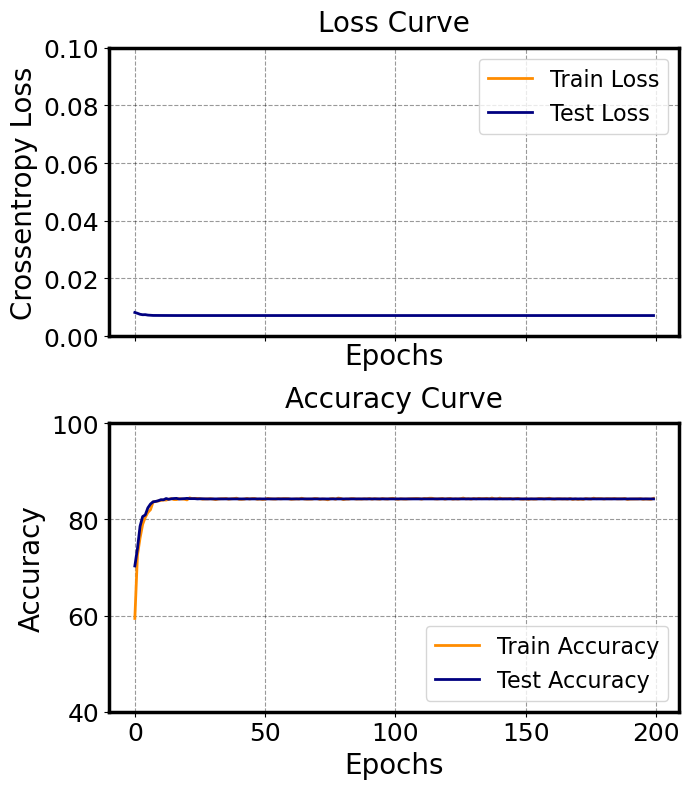

In [38]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 200, "Initial Training",
              interval=50, yloss_limit1=0, yloss_limit2=0.1, yacc_limit1=40, yacc_limit2=100)

save_fig ("train_lost_curve_audio")

In [40]:
get_accuracy(model, test_dataloader, device)

0.8528446389496718

Test Accuracy (cross-validation) for MFCC-CNN = 0.84273 ± 0.01047
micro-averaging AUC for MFCC-CNN = 0.93689 ± 0.00000
Saving figure ROC_curve (acoustic-based)-raw


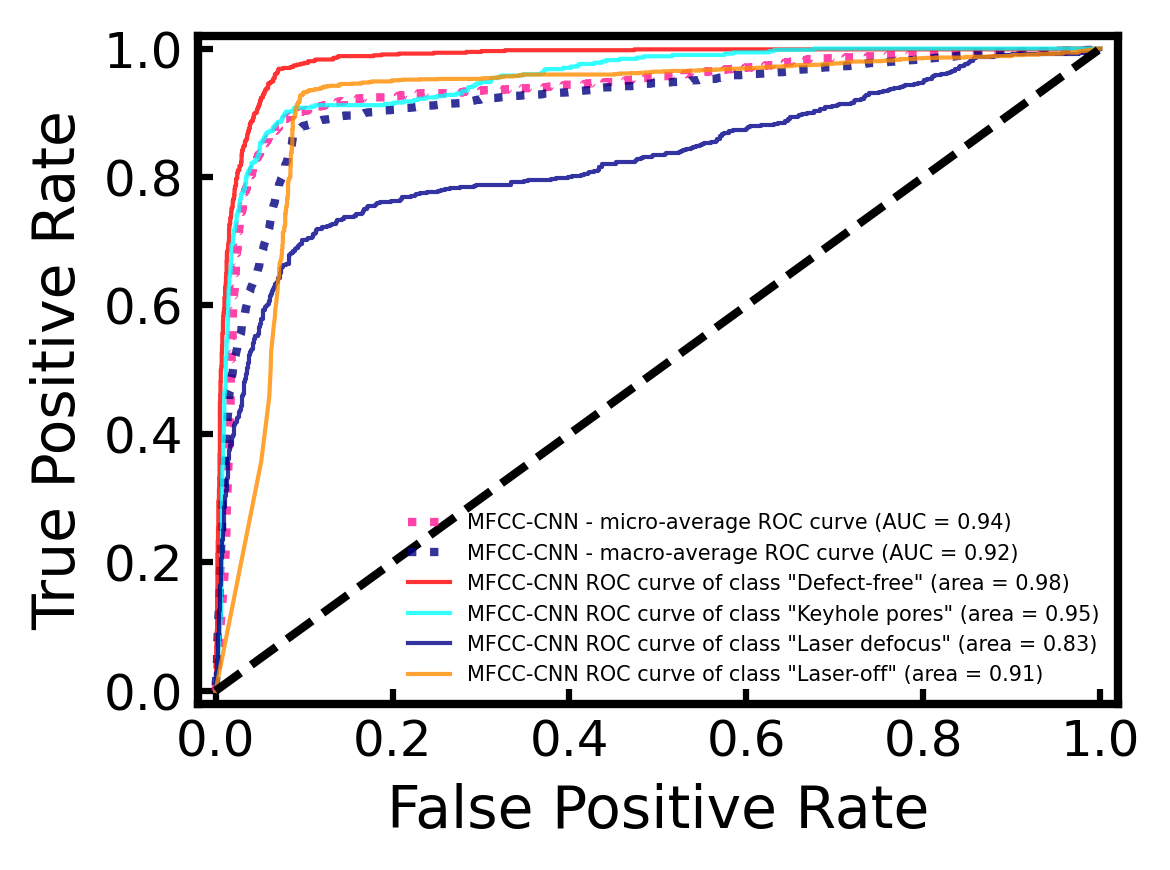

In [41]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "MFCC-CNN", 
                                                                            signal_type = "raw", seed=0)

save_fig ("ROC_curve (acoustic-based)-raw")

In [42]:
yt, yp = class_report(model, val_dataloader, device, classes)

               precision    recall  f1-score   support

  Defect-free     0.8297    0.9105    0.8683       760
Keyhole pores     0.7864    0.7896    0.7880       499
Laser defocus     0.7216    0.5427    0.6195       621
    Laser-off     0.8943    0.9336    0.9135      1776

     accuracy                         0.8427      3656
    macro avg     0.8080    0.7941    0.7973      3656
 weighted avg     0.8368    0.8427    0.8370      3656



[[ 692    5   39   24]
 [   6  394   52   47]
 [  95   64  337  125]
 [  41   38   39 1658]]
Saving figure confusion_matrix(audio_based)-raw


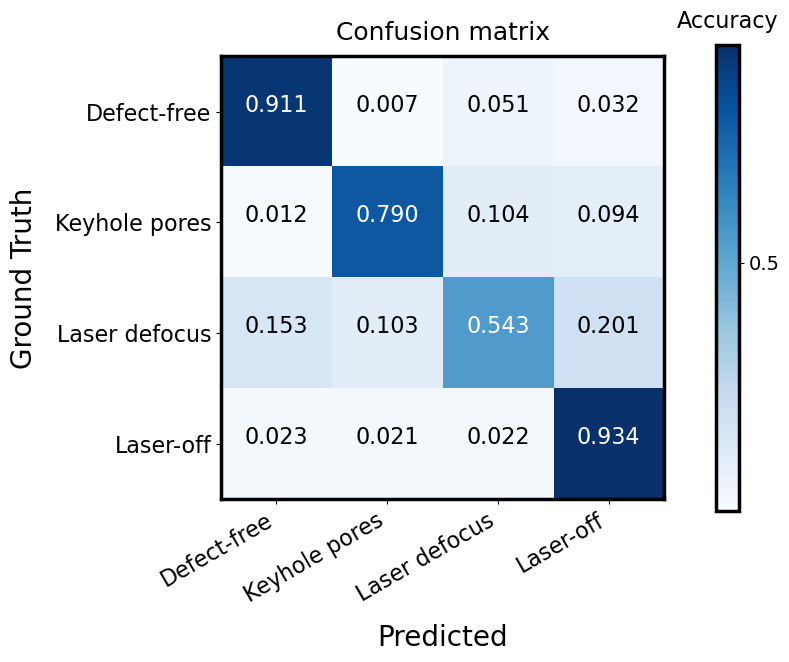

In [43]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_based)-raw")

### Save the trained model into the folder

In [44]:
# Save the model's state_dict
torch.save(model.state_dict(), os.path.join(model_path, 'trained_audio_MFCC-CNN(raw).pth'))

# Load the trained model to test

In [45]:
# Initialize your model
model = nn.DataParallel(MFCCCNN())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the state dictionary
model.load_state_dict(torch.load(os.path.join(model_path, 'trained_audio_MFCC-CNN(raw).pth')))


model.eval()  # Set the model to evaluation mode

DataParallel(
  (module): MFCCCNN(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.5, inplace=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (dropout2): Dropout(p=0.5, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=3584, out_features=128, bias=True)
    (dropout3): Dropout(p=0.5, inplace=False)
    (fc2): Linear(in_features=128, out_features=4, bias=True)
    (softmax): Softmax(dim=1)
  )
)

### Random testing

Predicted label index: 3
Predicted class name: Laser-off


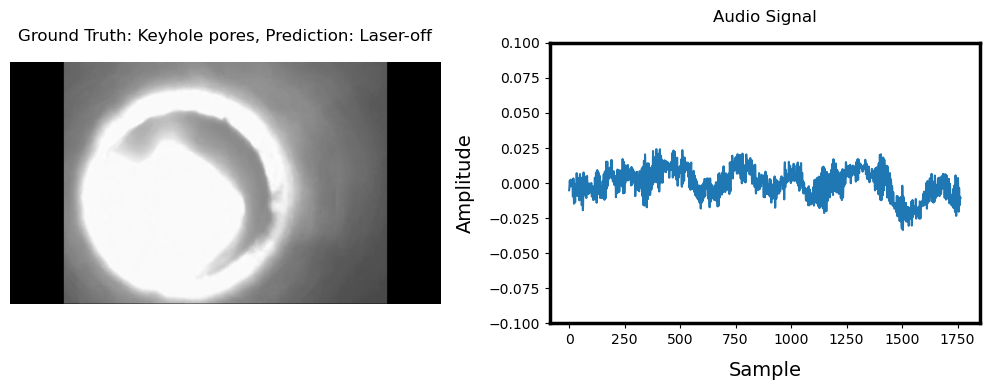

In [58]:
import PIL.Image

# Load and preprocess the image
sample_number = 24
index = 16127
img_path = os.path.join(Dataset_path, f"{sample_number}/images/sample_{sample_number}_{index}.jpg")
audio_path = os.path.join(Dataset_path, f"{sample_number}/raw_audio/sample_{sample_number}_{index}.wav")
input_image = PIL.Image.open(img_path).convert('L')  
# apply transform
waveform, sample_rate = torchaudio.load(audio_path)
waveform = waveform.to(device)
input_tensor = mel_spectrogram(waveform)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input to the GPU if available
input_batch = input_batch.to(device)

# Make the prediction
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get the label, use argmax to get the index of the maximum score
_, predicted_label_index = torch.max(output, 1)


print(f"Predicted label index: {predicted_label_index.item()}")


# (1) Map the predicted index to the actual class name
index_to_class = {
    0: 'Defect-free',
    1: 'Keyhole pores',
    2: 'Laser defocus',
    3: 'Laser-off'
}


predicted_class_name = index_to_class[predicted_label_index.item()]
print(f"Predicted class name: {predicted_class_name}")

# (2) Display the image and print the ground truth label
try:
    ground_truth_label = df_multimodal.loc[
        (df_multimodal['Sample number'] == sample_number) & 
        (df_multimodal['image_file_name'] == f"sample_{sample_number}_{index}.jpg"), 
        'class_name_v3'
    ].iloc[0]
except IndexError:
    ground_truth_label = "NaN"


# Display the image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title(f"Ground Truth: {ground_truth_label}, Prediction: {predicted_class_name}", pad=15)
plt.axis('off')

# Load and plot the audio signal
waveform, sample_rate = torchaudio.load(audio_path)
plt.subplot(1, 2, 2)
plt.plot(waveform.t().numpy())
plt.title('Audio Signal', pad=15)
plt.xlabel('Sample', labelpad=10)
plt.ylabel('Amplitude', labelpad=10)
plt.ylim([-0.1, 0.1])
plt.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()